In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# load python functions and modules
import funcs
import mrsobs
from distortionMaps import d2cMapping

import numpy as np
from astropy.io import fits
from shapely.geometry import Point
import shapely.affinity
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# set user directories
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
lvl1path = '/Volumes/miri_mrs_data/FM_MRS/'
lvl2path = workDir+'FM_data/LVL2/'
cdpDir   = workDir+'cdp_data/'

**Let's load the LVL1 data**

In [6]:
# Get data
sci_exp_filename,ignore_bkg   = mrsobs.FM_MTS_BB_extended_source(lvl1path,'1A',bb_temp='800K',output='filename')
sci_exp_hdu   = fits.open(sci_exp_filename.replace('_LVL2',''))
sci_exp_ramp  = (sci_exp_hdu[0].data).astype('float')

#-- print header 
# print(repr(sci_exp_hdu[0].header))

In [7]:
nints = sci_exp_hdu[0].header['NINT']
ngroups = sci_exp_hdu[0].header['NGROUP']
frame_delta_time = sci_exp_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('LVL1 data shape: {}'.format(sci_exp_ramp.shape))

Number of integrations: 6
Number of groups/frames per integration: 20
LVL1 data shape: (120, 1280, 1032)


**Plot MIRI ramp image**

<IPython.core.display.Javascript object>


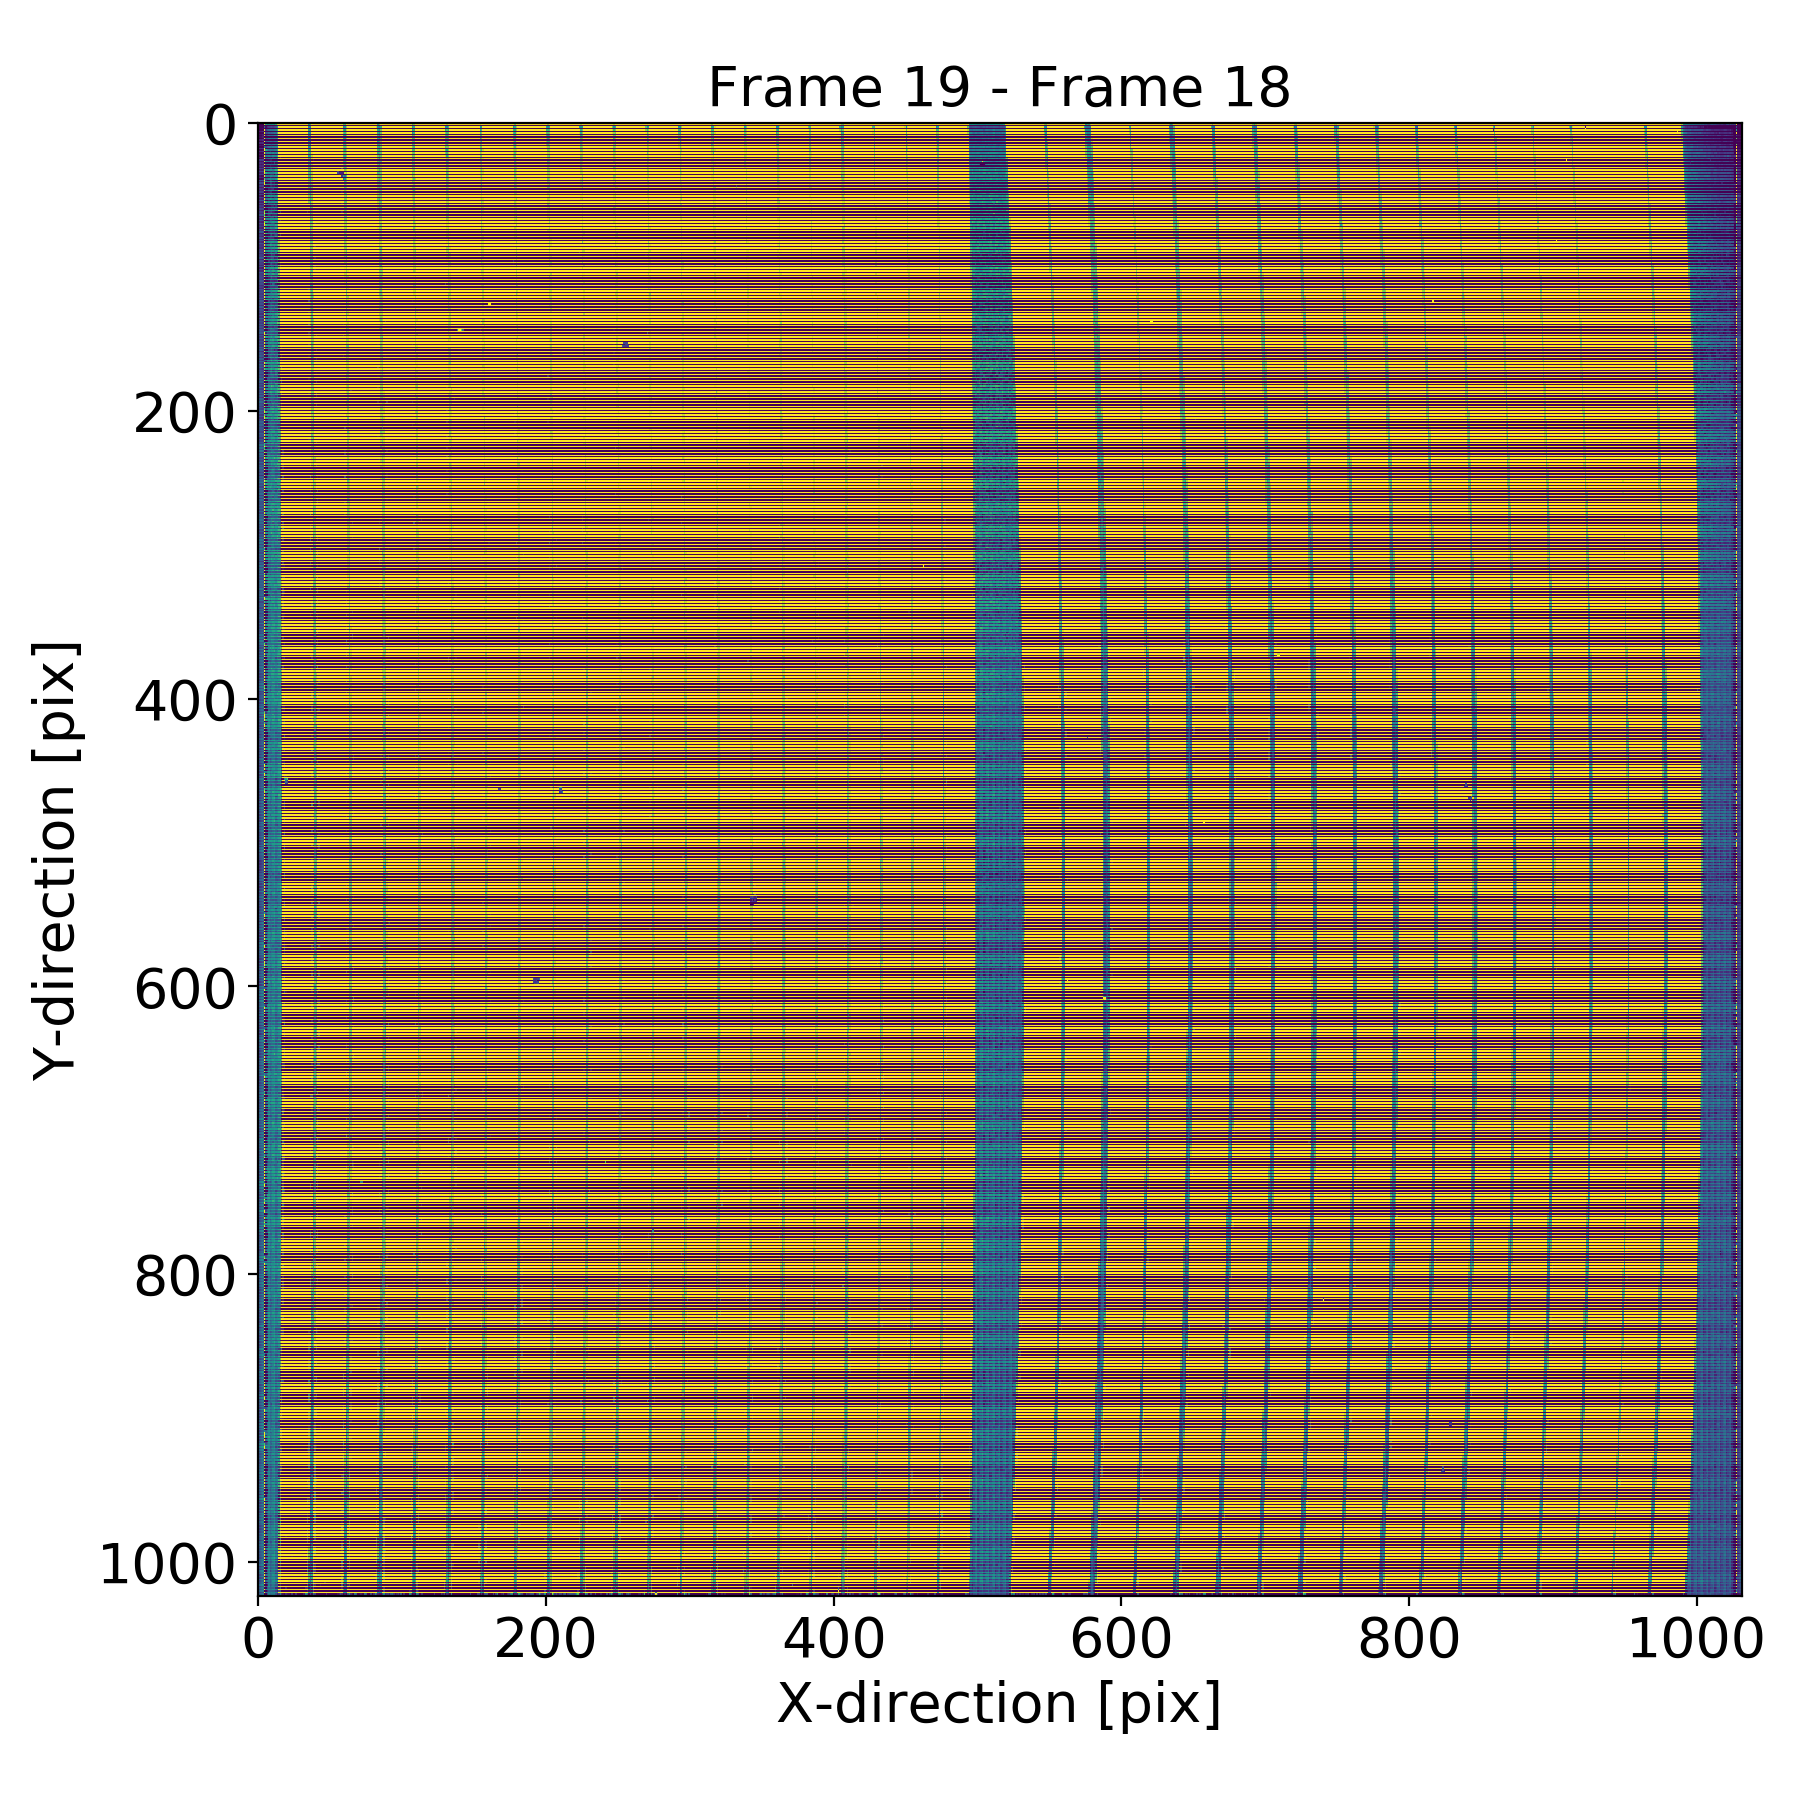

<IPython.core.display.Javascript object>


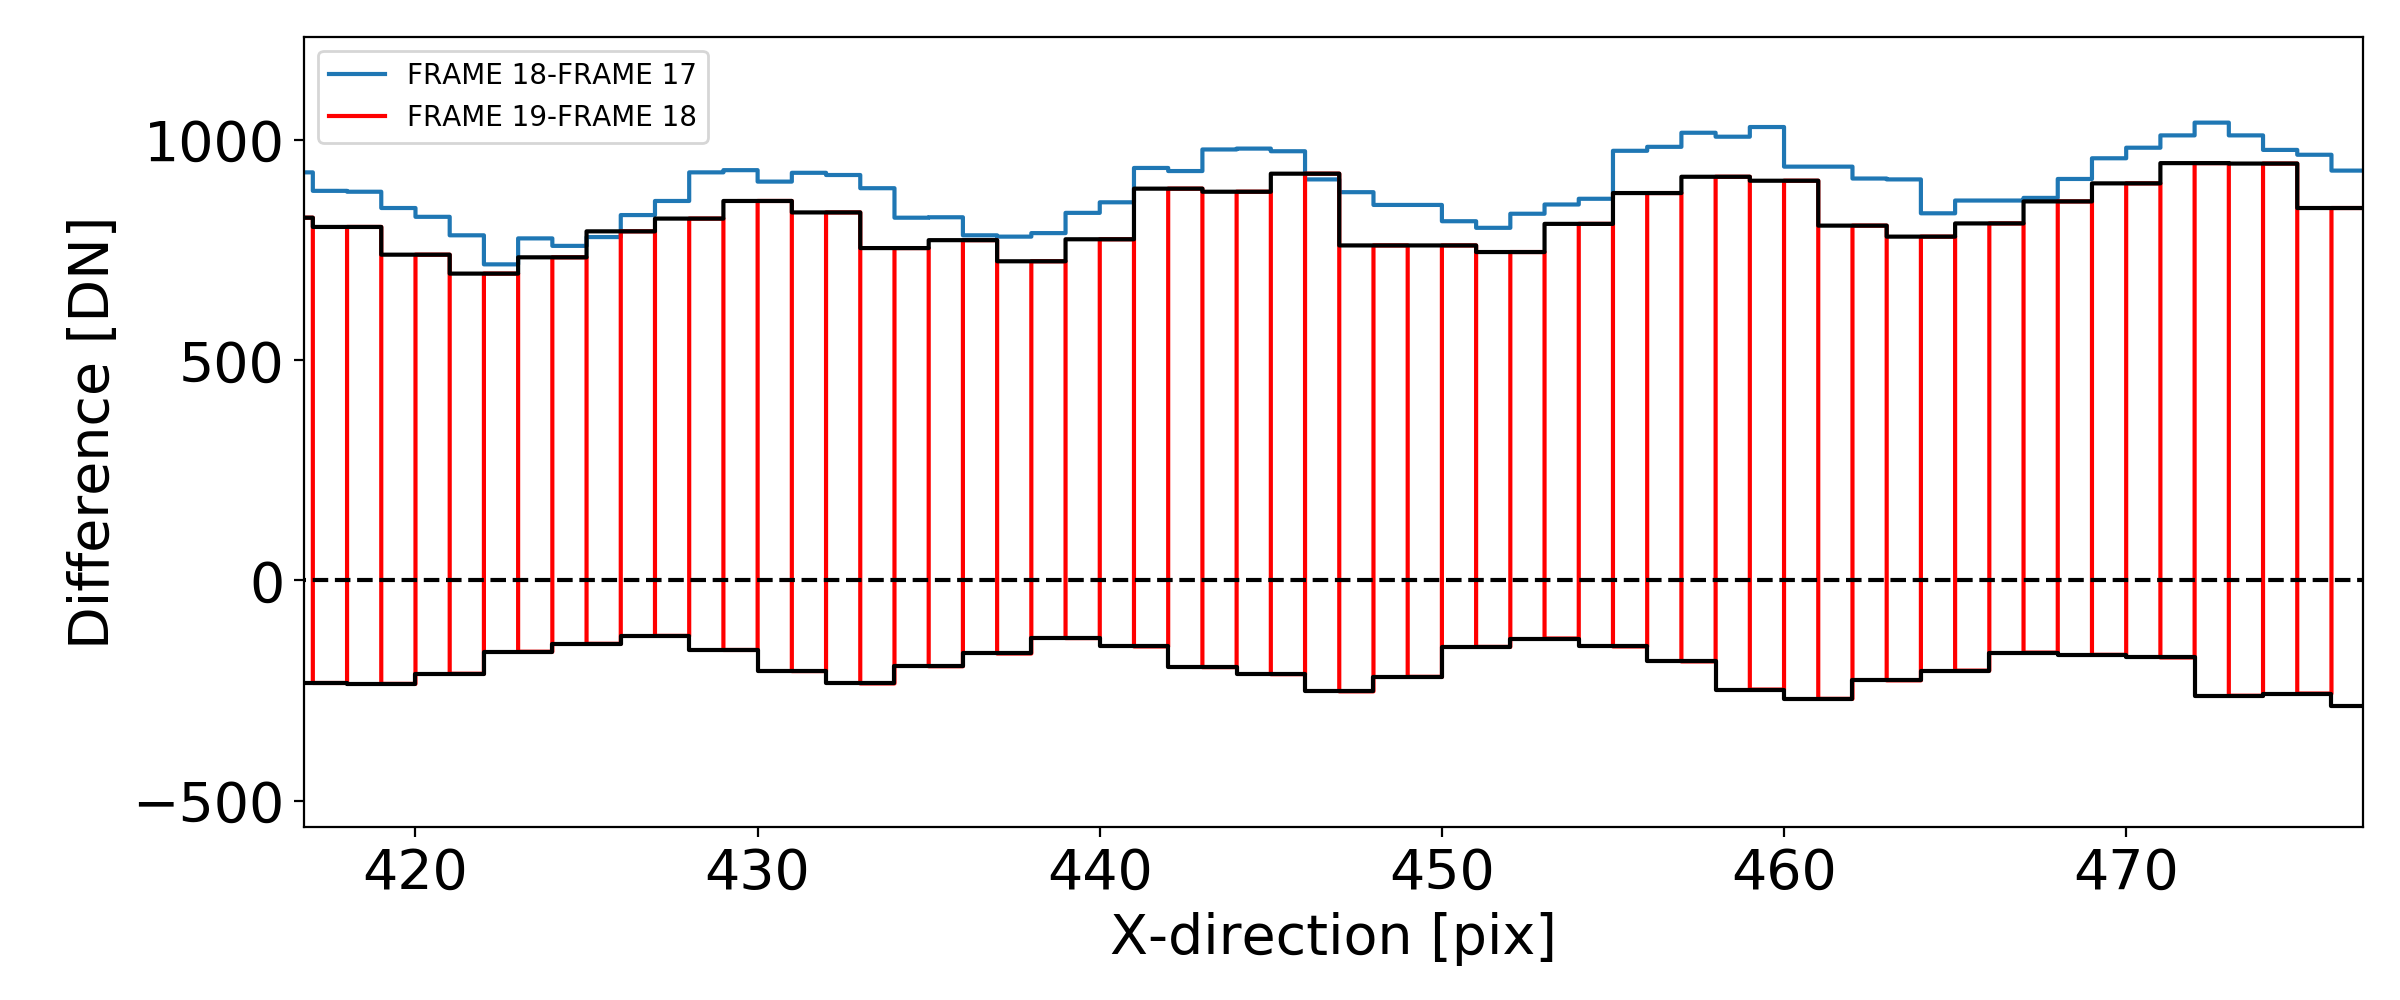

In [15]:
plt.figure(figsize=(9,9))
plt.title('Frame {} - Frame {}'.format(ngroups-1,ngroups-2))
plt.imshow(sci_exp_ramp[ngroups-1,:1024,:]-sci_exp_ramp[ngroups-2,:1024,:],vmin=0,vmax=200)
plt.xlabel('X-direction [pix]')
plt.ylabel('Y-direction [pix]')
plt.tight_layout()

d2cMapDir = workDir+'notebooks/distortionMaps/'
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr10pc'.format('2A'),path=d2cMapDir)
ypos,xpos = funcs.detpixel_trace('2A',d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
# ypos,xpos = np.arange(1024), (np.ones(1024)*120).astype(int)

plt.figure(figsize=(12,5))
plt.step(np.arange(len(ypos)),(sci_exp_ramp[ngroups-2,ypos,xpos]-sci_exp_ramp[ngroups-3,ypos,xpos]),zorder=0,label='FRAME {}-FRAME {}'.format(ngroups-2,ngroups-3))
plt.step(sci_exp_ramp[ngroups-1,ypos,xpos]-sci_exp_ramp[ngroups-2,ypos,xpos],'r',zorder=0,label='FRAME {}-FRAME {}'.format(ngroups-1,ngroups-2))
sel = (sci_exp_ramp[ngroups-1,ypos,xpos]-sci_exp_ramp[ngroups-2,ypos,xpos])<0
plt.step(np.arange(len(ypos))[sel],(sci_exp_ramp[ngroups-1,ypos,xpos]-sci_exp_ramp[ngroups-2,ypos,xpos])[sel],'k')
sel = (sci_exp_ramp[ngroups-1,ypos,xpos]-sci_exp_ramp[ngroups-2,ypos,xpos])>0
plt.step(np.arange(len(ypos))[sel],(sci_exp_ramp[ngroups-1,ypos,xpos]-sci_exp_ramp[ngroups-2,ypos,xpos])[sel],'k')
plt.hlines(0,0,1024,'k',linestyle='dashed',zorder=1)
plt.legend(loc='upper left',fontsize=10)
plt.xlabel('X-direction [pix]')
plt.ylabel('Difference [DN]')
plt.tight_layout()

**Let's look at the integration ramps for one pixel**

<IPython.core.display.Javascript object>


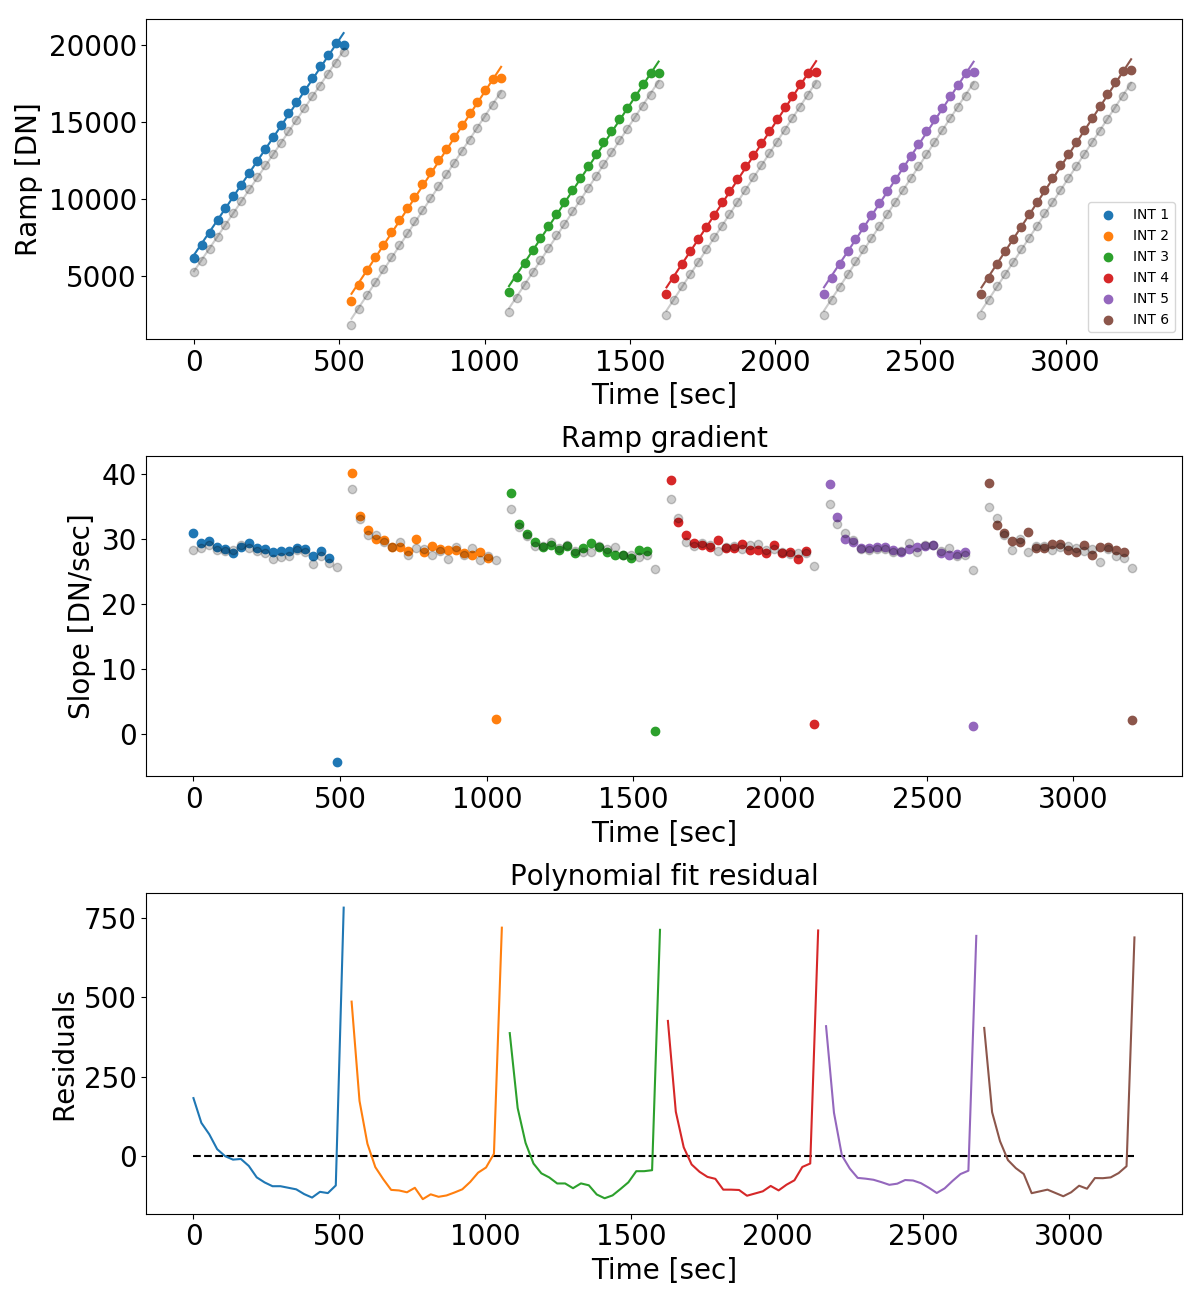

Determined slopes per integration: [27.97, 28.6, 28.3, 28.52, 28.43, 28.76] DN/sec
Determined slopes per integration (excluding last frame): [28.47, 29.07, 28.76, 28.98, 28.88, 29.21] DN/sec


In [33]:
ypos,xpos = 178,27
fig,axs = plt.subplots(3,1,figsize=(12,13))
slopes,slopes_minus_last_frame = [],[]
for i in range(nints):
    xdata  = np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups]*frame_delta_time
    ydata  = sci_exp_ramp[i*ngroups:(i+1)*ngroups,ypos,xpos]
    
    xdata2  = np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups]*frame_delta_time
    ydata2  = sci_exp_ramp[i*ngroups:(i+1)*ngroups,ypos-1,xpos]
    n_poly = 1
    
    popt = np.polyfit(xdata,ydata,n_poly)
    popt_minus_last_frame = np.polyfit(xdata[:-1],ydata[:-1],n_poly)
    poly = np.poly1d(popt)
    
    popt2 = np.polyfit(xdata2,ydata2,n_poly)
    poly2 = np.poly1d(popt2)
    
    slopes.append(round(popt[0],2))
    slopes_minus_last_frame.append(round(popt_minus_last_frame[0],2))
    
    residuals = poly(xdata)-ydata

    axs[0].plot(xdata,poly(xdata))
    axs[0].scatter(xdata,ydata,label='INT {}'.format(i+1))
    axs[0].plot(xdata2,poly2(xdata2),'k',alpha=0.2)
    axs[0].plot(xdata2,ydata2,'ko',alpha=0.2)
    axs[0].set_xlabel('Time [sec]')
    axs[0].set_ylabel('Ramp [DN]')
    axs[0].legend(loc='lower right',fontsize=10)
    axs[1].set_title('Ramp gradient')
    axs[1].scatter(xdata[:-1],np.diff(ydata)/frame_delta_time)
    axs[1].plot(xdata2[:-1],np.diff(ydata2)/frame_delta_time,'ko',alpha=0.2)
    axs[1].set_xlabel('Time [sec]')
    axs[1].set_ylabel('Slope [DN/sec]')
    axs[2].plot(xdata,residuals)
    axs[2].set_title('Polynomial fit residual')
    axs[2].set_xlabel('Time [sec]')
    axs[2].set_ylabel('Residuals')
axs[2].hlines(0,0,xdata[-1],linestyle='dashed')
plt.tight_layout()

print ('Determined slopes per integration: {} DN/sec'.format(slopes))
print ('Determined slopes per integration (excluding last frame): {} DN/sec'.format(slopes_minus_last_frame))

**Let's correct for the reset-switch-charge-decay (dummy correction)**

In [11]:
rscdCorrection = fits.open(cdpDir+'MIRI_FM_MIRIFUSHORT_12_RSCD_06.00.00.fits')[1].data
print('RSCD parameters: \n{}'.format(rscdCorrection))

tau = rscdCorrection[0][3]   # e-folding time scale (in units of seconds)
scale_factor = rscdCorrection[0][4]

sci_exp_ramp   = sci_exp_ramp[:,:1024,:] # ommit non-sensitive pixels
sci_exp_ramp_rscdCorr = np.full(sci_exp_ramp.shape,0.)
sci_exp_ramp_rscdCorr[:ngroups,:,:] = sci_exp_ramp[:ngroups,:,:]
for i in range(1,nints):
    # time since the last frame in the previous integration (units seconds)
    T = (np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups]*frame_delta_time-np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups][0]*frame_delta_time)+frame_delta_time
    # data of previous integration
    ydata_previousINT  = sci_exp_ramp[(i-1)*ngroups:i*ngroups,ypos,xpos]
    # accumulated DNs over previous integration
    DN_accumulated = ydata_previousINT[-1]-ydata_previousINT[0]
    
    # apply correction
    timeMap = np.full(sci_exp_ramp_rscdCorr[i*ngroups:(i+1)*ngroups,:,:].shape,0.)
    for j in range(len(T)):
        timeMap[j,:,:] = T[j]
    sci_exp_ramp_rscdCorr[i*ngroups:(i+1)*ngroups,:,:] = sci_exp_ramp[i*ngroups:(i+1)*ngroups,:,:] + DN_accumulated * scale_factor * np.exp(-timeMap/tau)

RSCD parameters: 
[('FULL', 'SLOW', 'EVEN', 1.55, 0.05, 0., 0.)
 ('FULL', 'SLOW', 'ODD', 1.55, 0.05, 0., 0.)
 ('FULL', 'FAST', 'EVEN', 1.55, 0.05, 0., 0.)
 ('FULL', 'FAST', 'ODD', 1.55, 0.05, 0., 0.)]


**Let's correct for the non-linearity**

In [12]:
linearityCorrection = fits.open(cdpDir+'MIRI_FM_RAL_MIRIFUSHORT_12_LINEARITY_07.02.00.fits')[1].data

sci_exp_ramp_linCorr = np.full(sci_exp_ramp.shape,0.)
for i in range(sci_exp_ramp.shape[0]):
    sci_exp_ramp_linCorr[i,:,:] += linearityCorrection[0,:,:]+\
                                    linearityCorrection[1,:,:]*sci_exp_ramp_rscdCorr[i,:,:]+\
                                    linearityCorrection[2,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**2+\
                                    linearityCorrection[3,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**3+\
                                    linearityCorrection[4,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**4

print('Linearity correction factors for pixel ({},{}): \n Bias: {} \n Linear term: {} \n Quadratic term: {} \n 3rd order term: {} \n 4th order term: {}'.format(ypos,xpos,linearityCorrection[0,ypos,xpos],linearityCorrection[1,ypos,xpos],linearityCorrection[2,ypos,xpos],linearityCorrection[3,ypos,xpos],linearityCorrection[4,ypos,xpos]))

Linearity correction factors for pixel (177,27): 
 Bias: 0.0 
 Linear term: 0.8899639844894409 
 Quadratic term: 3.1366600978799397e-06 
 3rd order term: -2.320923314647061e-11 
 4th order term: 3.9334748938655694e-16


<IPython.core.display.Javascript object>


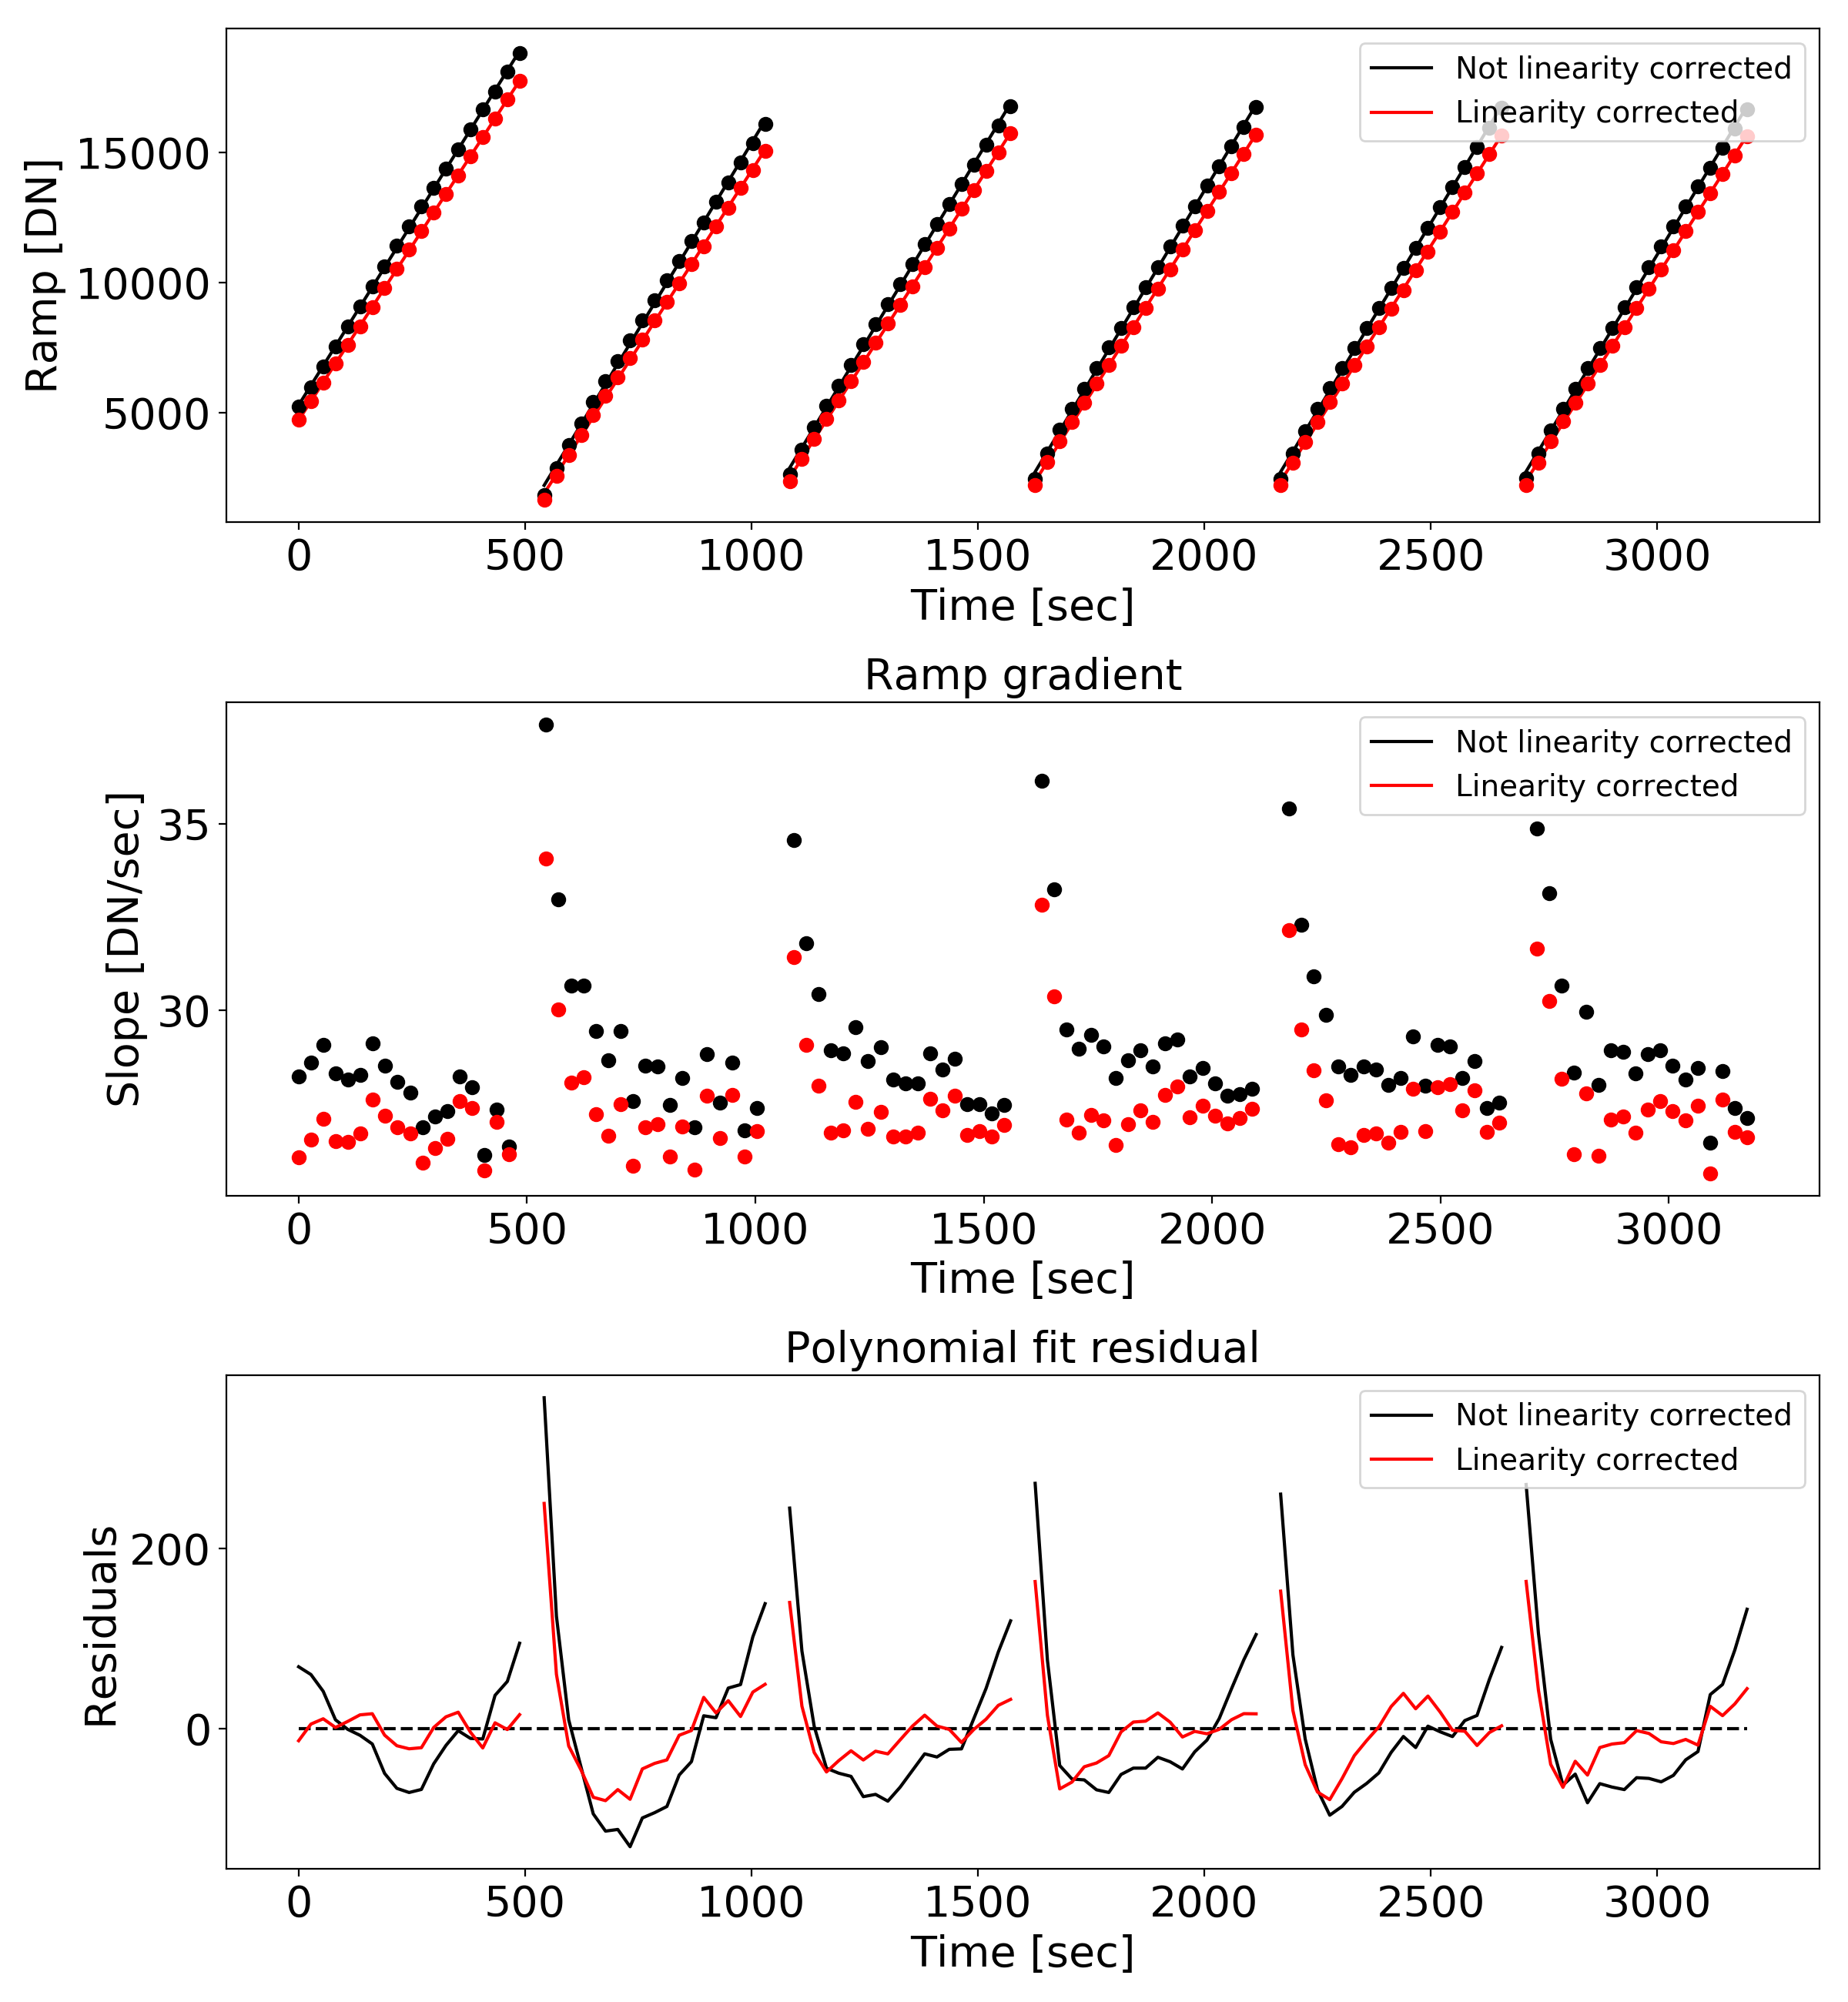

Determined slopes per integration (non-linearity uncorrected): [27.91, 28.73, 28.72, 28.92, 28.84, 28.78] DN/sec
Determined slopes per integration (non-linearity corrected): [26.74, 27.08, 27.17, 27.35, 27.27, 27.21] DN/sec


In [13]:
ypos,xpos = 177,27
fig,axs = plt.subplots(3,1,figsize=(12,13))
slopes_noLinCorr,slopes_LinCorr,slopes_noLinCorr_minus_last_frame,slopes_LinCorr_minus_last_frame = [],[],[],[]
for i in range(nints):
    xdata  = np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups][:-1]*frame_delta_time
    ydata_noLinCorr  = sci_exp_ramp[i*ngroups:(i+1)*ngroups,ypos,xpos][:-1]
    ydata_LinCorr    = sci_exp_ramp_linCorr[i*ngroups:(i+1)*ngroups,ypos,xpos][:-1]
    
    n_poly = 1
    popt_noLinCorr = np.polyfit(xdata,ydata_noLinCorr,n_poly)
    popt_noLinCorr_minus_last_frame = np.polyfit(xdata[:-1],ydata_noLinCorr[:-1],n_poly)
    poly_noLinCorr = np.poly1d(popt_noLinCorr)
    
    popt_LinCorr = np.polyfit(xdata,ydata_LinCorr,n_poly)
    popt_LinCorr_minus_last_frame = np.polyfit(xdata[:-1],ydata_LinCorr[:-1],n_poly)
    poly_LinCorr = np.poly1d(popt_LinCorr)
    
    slopes_noLinCorr.append(round(popt_noLinCorr[0],2))
    slopes_LinCorr.append(round(popt_LinCorr[0],2))
    slopes_noLinCorr_minus_last_frame.append(round(popt_noLinCorr_minus_last_frame[0],2))
    slopes_LinCorr_minus_last_frame.append(round(popt_LinCorr_minus_last_frame[0],2))
    
    residuals_noLinCorr = poly_noLinCorr(xdata)-ydata_noLinCorr
    residuals_LinCorr   = poly_LinCorr(xdata)-ydata_LinCorr

    axs[0].plot(xdata,poly_noLinCorr(xdata),'k')
    axs[0].plot(xdata,poly_LinCorr(xdata),'r')
    axs[0].plot(xdata,ydata_noLinCorr,'ko')
    axs[0].plot(xdata,ydata_LinCorr,'ro')
    axs[0].set_xlabel('Time [sec]')
    axs[0].set_ylabel('Ramp [DN]')
    axs[1].set_title('Ramp gradient')
    axs[1].plot(xdata[:-1],np.diff(ydata_noLinCorr)/frame_delta_time,'ko')
    axs[1].plot(xdata[:-1],np.diff(ydata_LinCorr)/frame_delta_time,'ro')
    axs[1].set_xlabel('Time [sec]')
    axs[1].set_ylabel('Slope [DN/sec]')
    axs[2].plot(xdata,residuals_noLinCorr,'k')
    axs[2].plot(xdata,residuals_LinCorr,'r')
    axs[2].set_title('Polynomial fit residual')
    axs[2].set_xlabel('Time [sec]')
    axs[2].set_ylabel('Residuals')
legend_elements = [Line2D([0],[0],color='k',label='Not linearity corrected'),
                   Line2D([0],[0],color='r',label='Linearity corrected')]
for plot in range(3): axs[plot].legend(handles=legend_elements,loc='upper right')
axs[2].hlines(0,0,xdata[-1],linestyle='dashed')
plt.tight_layout()

print ('Determined slopes per integration (non-linearity uncorrected): {} DN/sec'.format(slopes_noLinCorr))
print ('Determined slopes per integration (non-linearity corrected): {} DN/sec'.format(slopes_LinCorr))

In [2]:
26.74/27.91

0.9580795413830168

**Load LVL2 data**

In [14]:
# Get data
sci_exp_slope_hdu_SW = fits.open(lvl2path+'FM1T00011282/MIRFM1T00011282_1_495_SE_2011-05-31T02h15m32_LVL2.fits')
sci_exp_slope_SW = sci_exp_slope_hdu_SW[0].data[0,:,:]
sci_exp_slope_hdu_LW = fits.open(lvl2path+'FM1T00011282/MIRFM1T00011282_1_494_SE_2011-05-31T02h15m02_LVL2.fits')
sci_exp_slope_LW = sci_exp_slope_hdu_LW[0].data[0,:,:]

# select data to use
sci_exp_slope_hdu = sci_exp_slope_hdu_SW
sci_exp_slope     = sci_exp_slope_SW

**Plot slope image (average slope, from all integration ramps)**

<IPython.core.display.Javascript object>


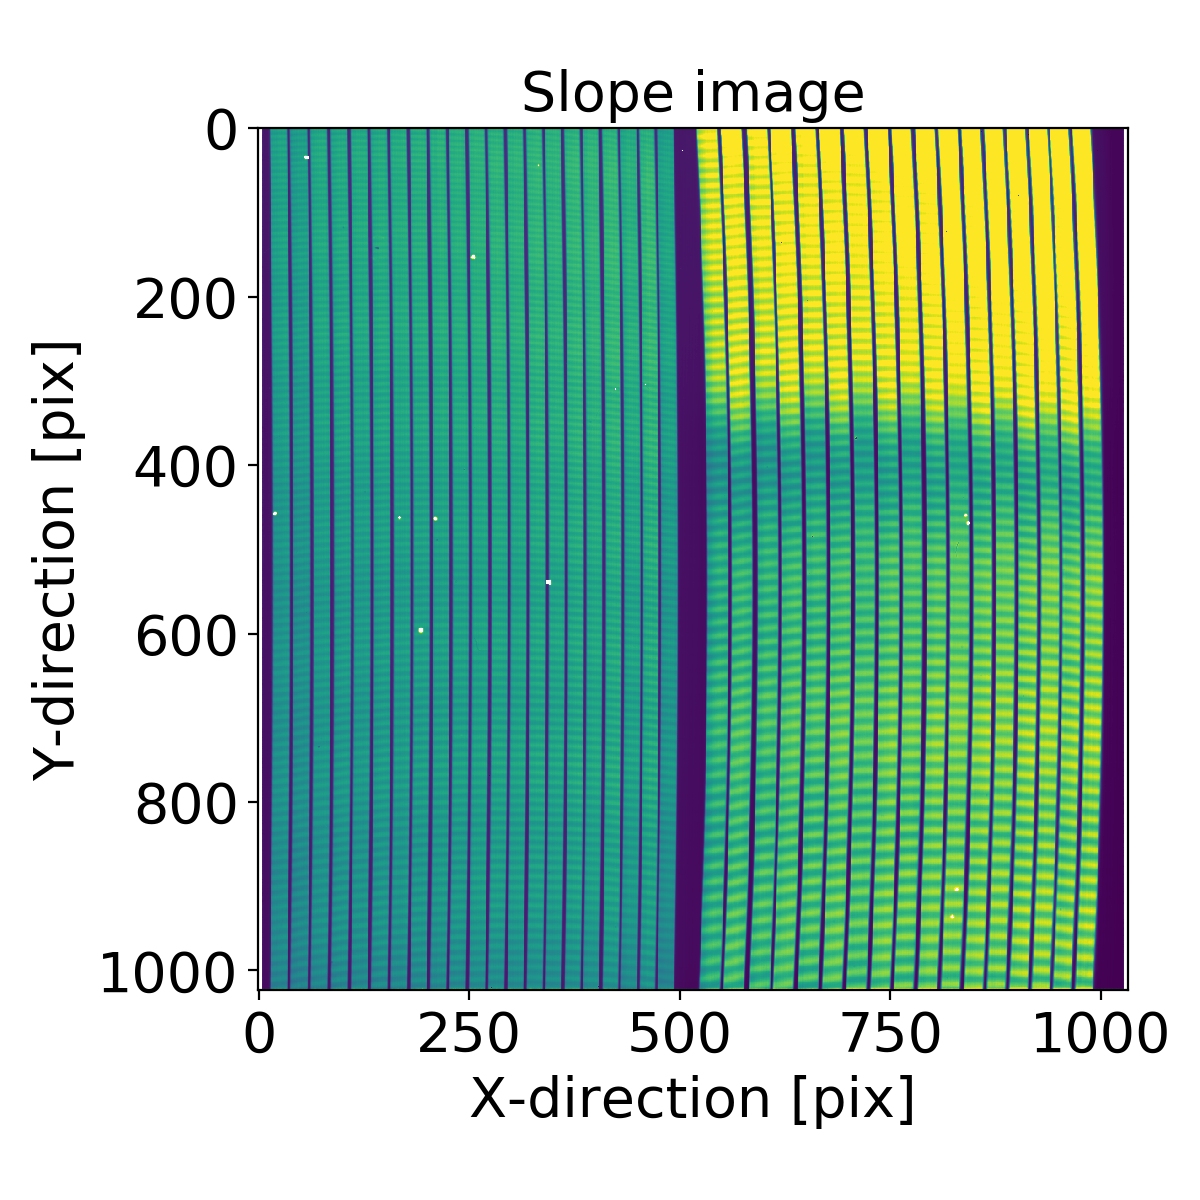

In [15]:
plt.figure(figsize=(6,6))
plt.title('Slope image')
plt.imshow(sci_exp_slope,vmin=0,vmax=50)
plt.xlabel('X-direction [pix]')
plt.ylabel('Y-direction [pix]')
plt.tight_layout()

**Load distortion maps**

In [16]:
d2cMaps = d2cMapping('1A',cdpDir+'CDP7/',fileversion='7B.05.01')

alphaMap  = d2cMaps['alphaMap']
betaMap   = d2cMaps['betaMap']
lambdaMap = d2cMaps['lambdaMap']
sliceMap  = d2cMaps['sliceMap']
nslices   = d2cMaps['nslices']

<IPython.core.display.Javascript object>


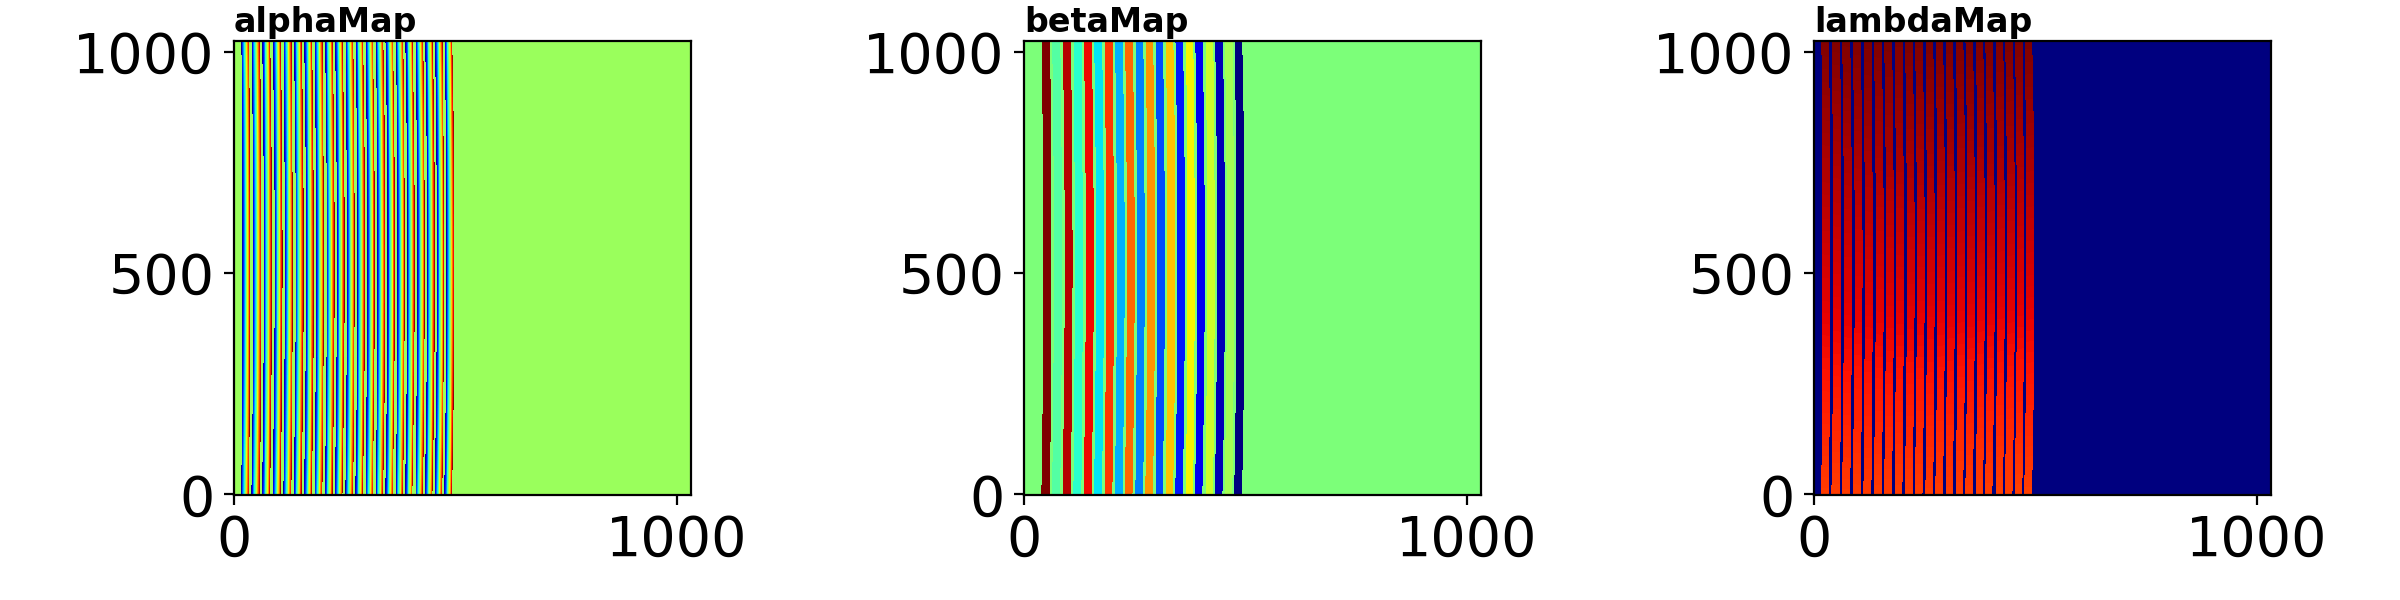

<IPython.core.display.Javascript object>


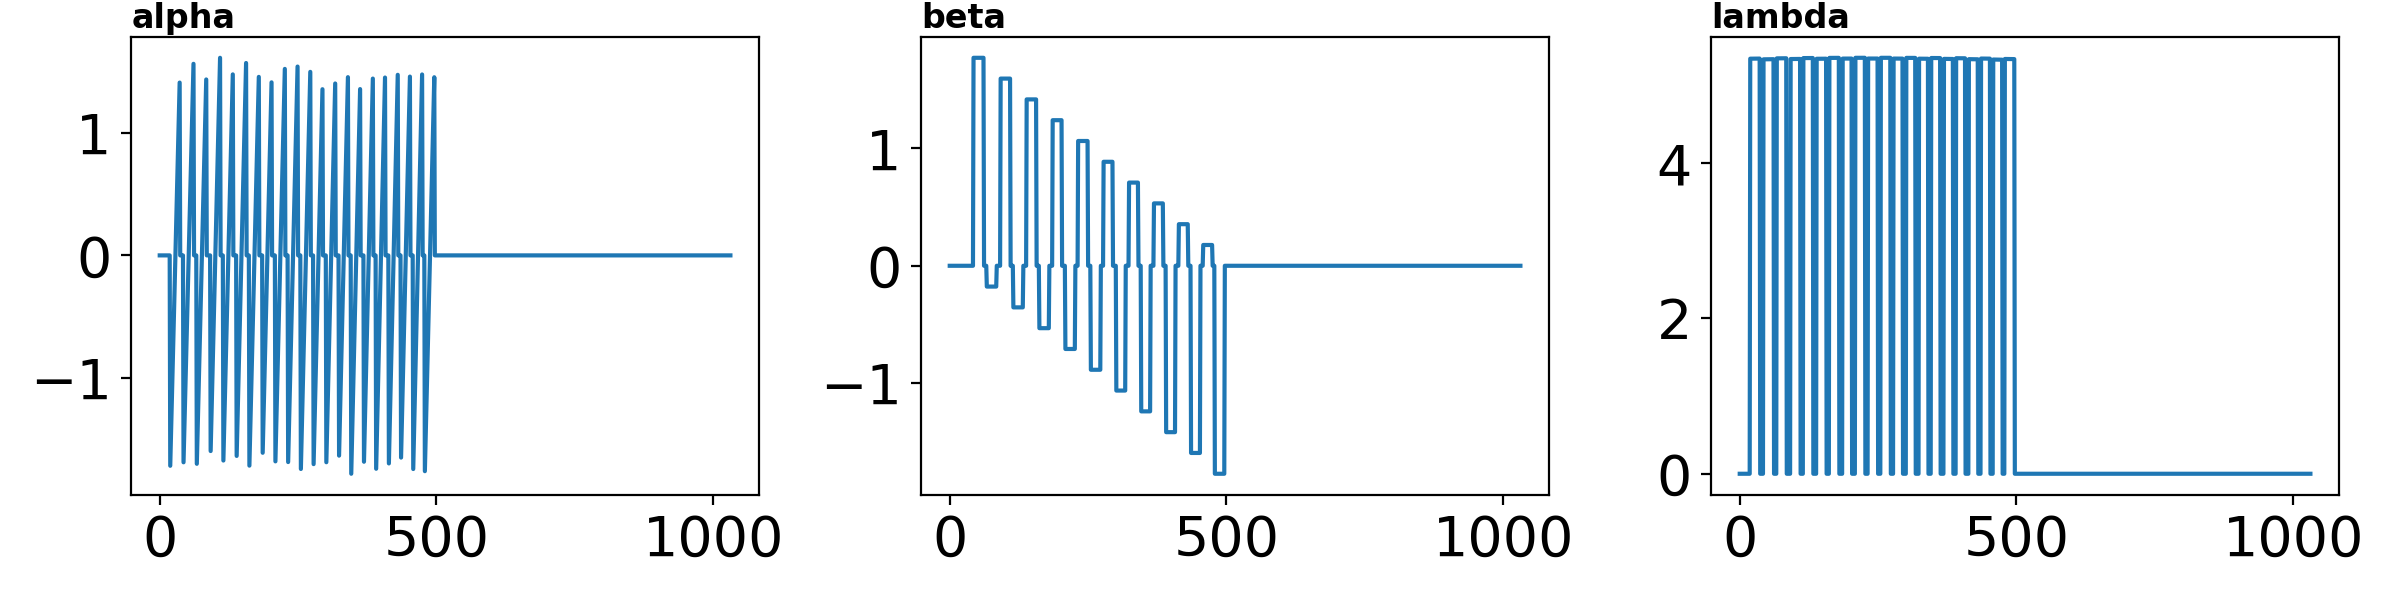

In [17]:
fig,axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].imshow(alphaMap,cmap='jet', interpolation='nearest', origin='lower')
axs[0].annotate('alphaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].imshow(betaMap,cmap='jet', interpolation='nearest', origin='lower')
axs[1].annotate('betaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].imshow(lambdaMap,cmap='jet', interpolation='nearest', origin='lower')
axs[2].annotate('lambdaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()
plt.show()

row = 512
fig,axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(alphaMap[row,:])
axs[0].annotate('alpha', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].plot(betaMap[row,:])
axs[1].annotate('beta', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].plot(lambdaMap[row,:])
axs[2].annotate('lambda', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()
plt.show()

**Let's plot the signal in a pixel trace (row/column) on the detector**

<IPython.core.display.Javascript object>


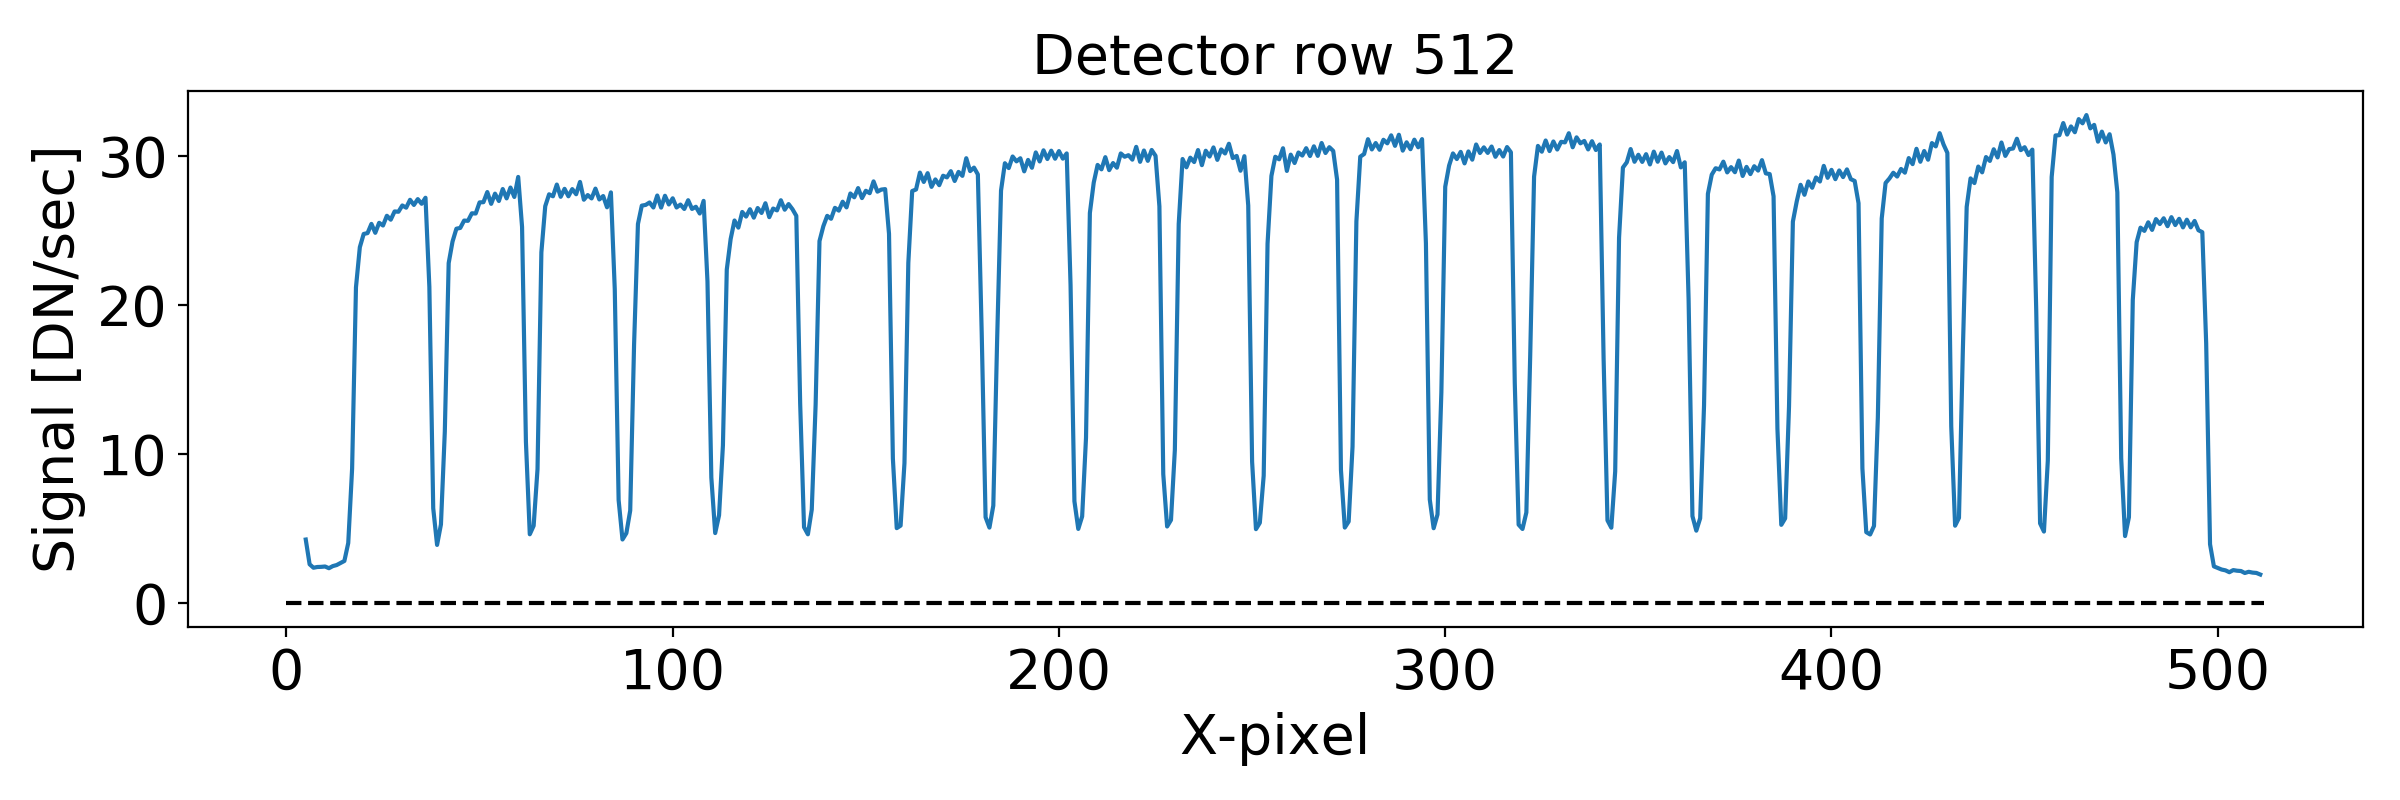

<IPython.core.display.Javascript object>


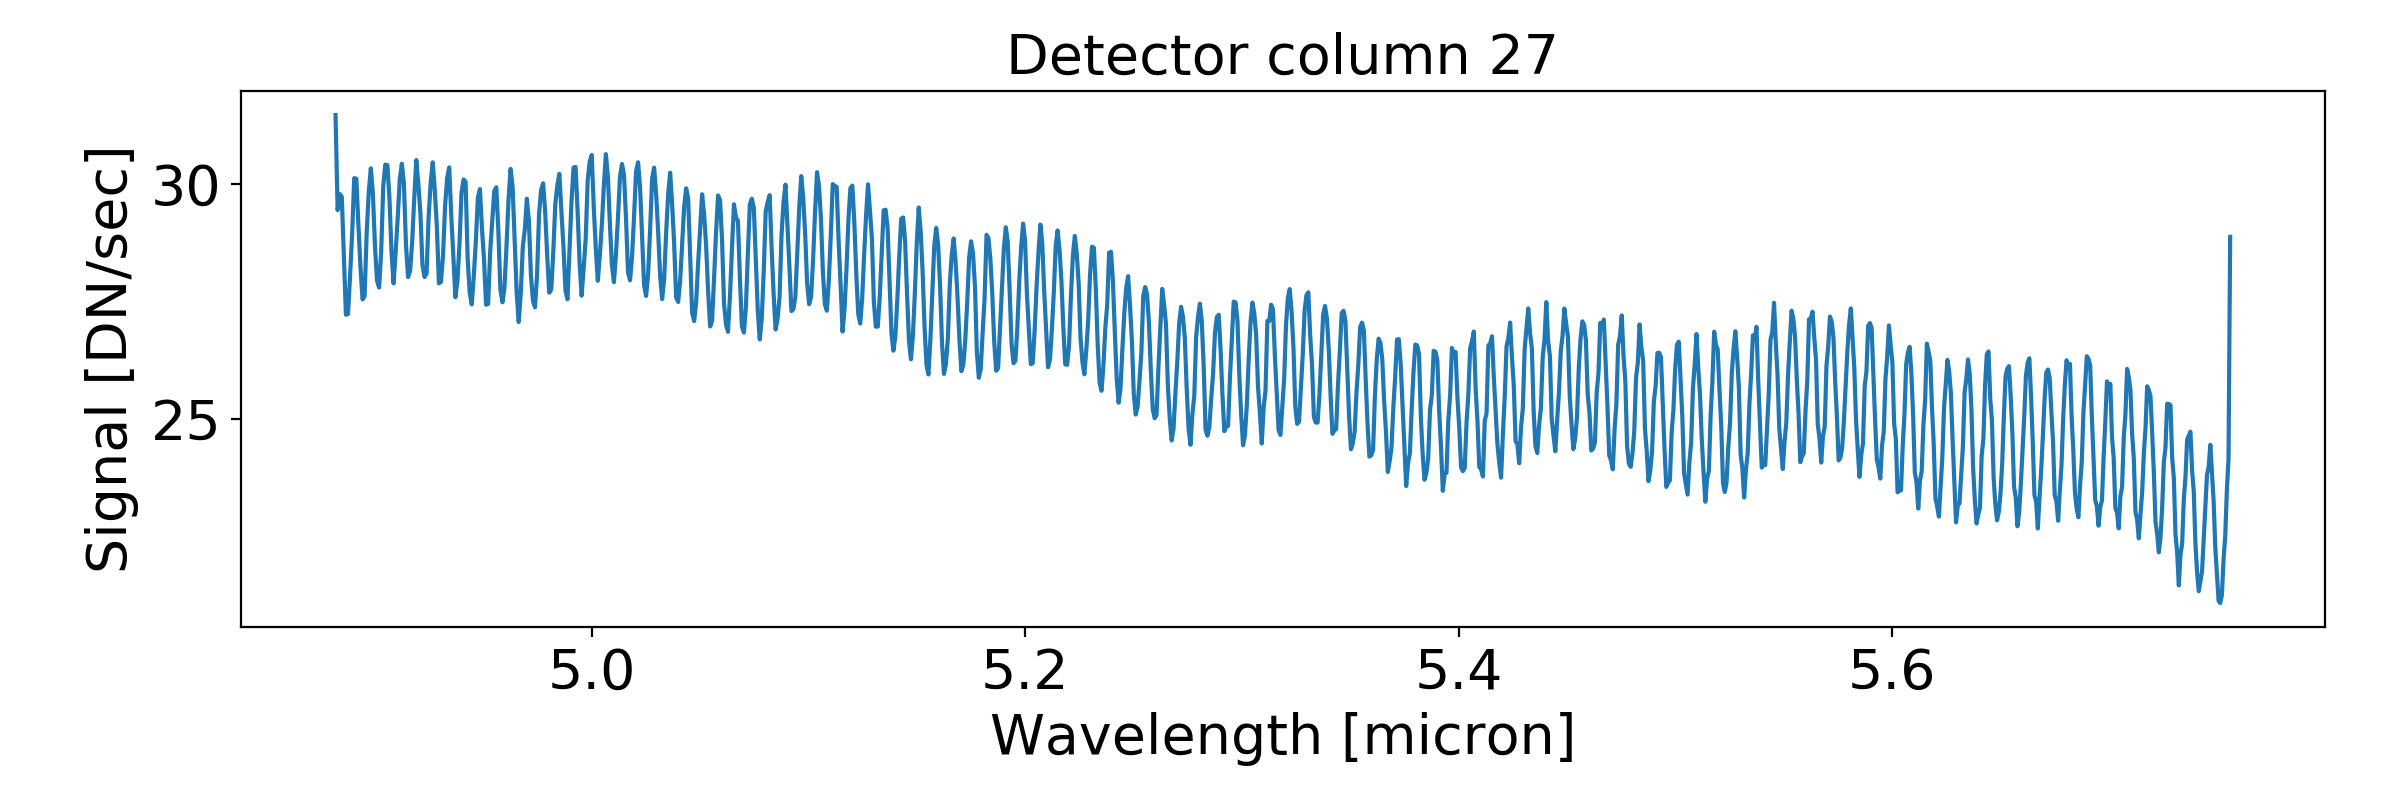

In [18]:
yrow = 512
plt.figure(figsize=(12,4))
plt.title('Detector row {}'.format(yrow))
plt.plot(sci_exp_slope[yrow,:512])
plt.hlines(0,0,512,'k',linestyle='dashed')
plt.xlabel('X-pixel')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

xcol = 27
plt.figure(figsize=(12,4))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],sci_exp_slope[:,xcol])
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

**Apply fringe correction**

<IPython.core.display.Javascript object>


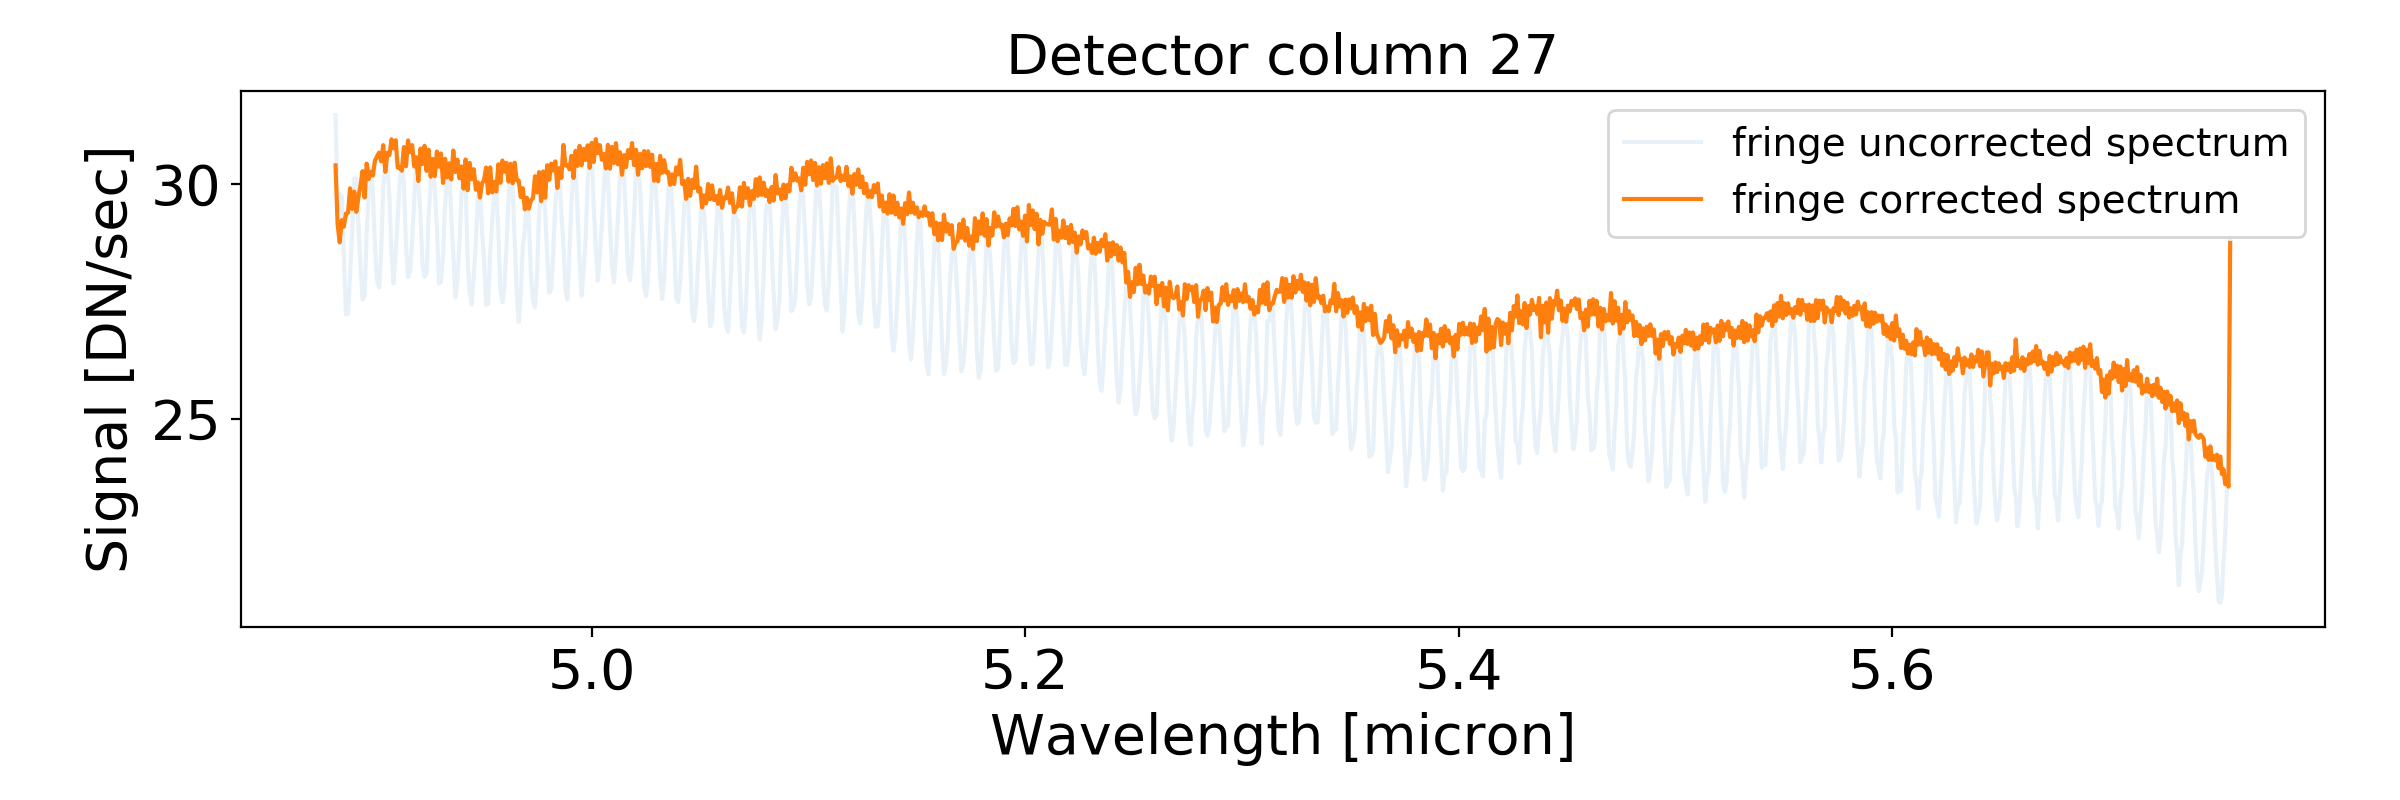

<IPython.core.display.Javascript object>


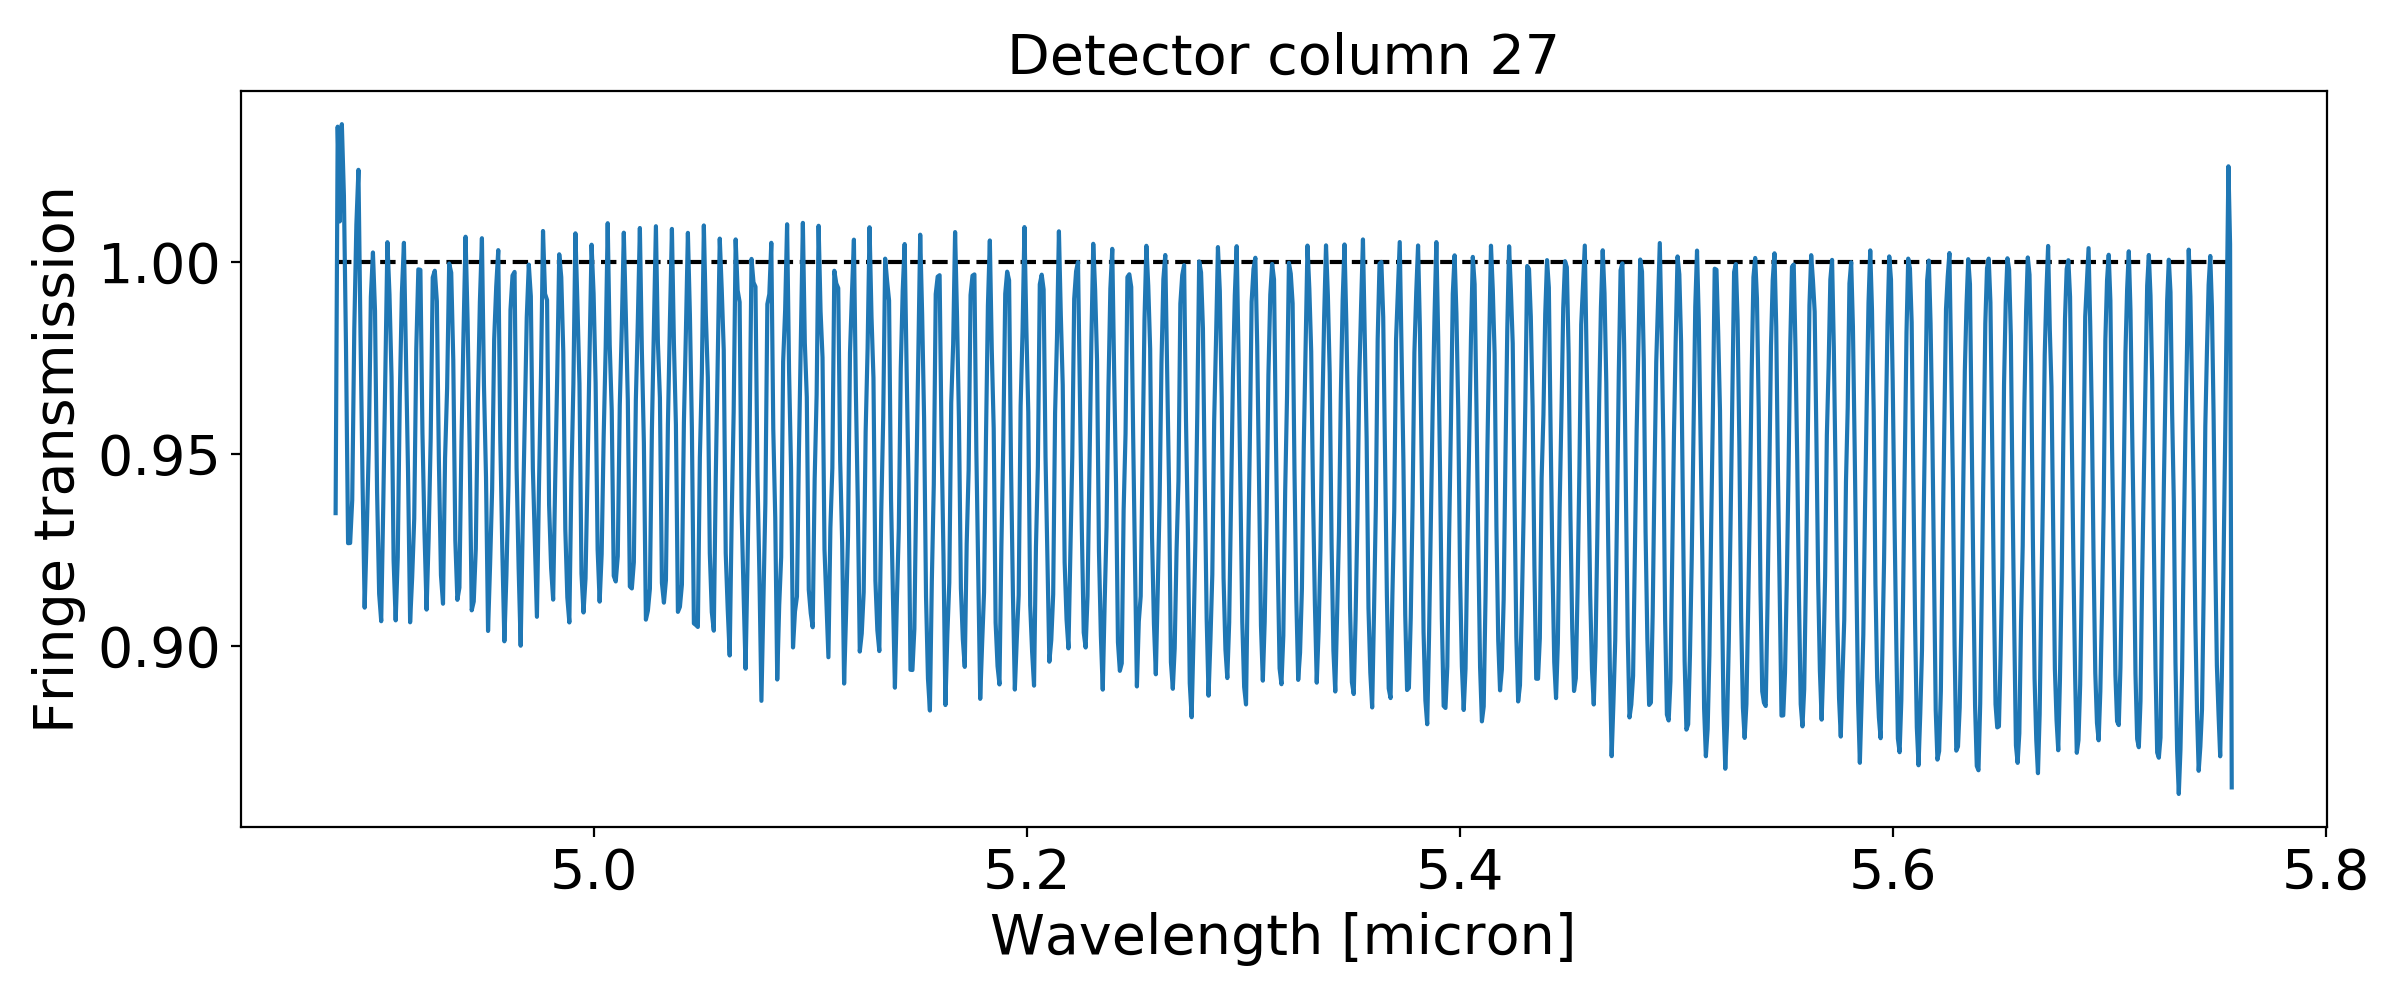

In [19]:
fringe_img = funcs.get_cdps('1A',cdpDir)[0]
sci_exp_slope_fringeCorr = sci_exp_slope/fringe_img

plt.figure(figsize=(12,4))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],sci_exp_slope[:,xcol],alpha=0.1,label='fringe uncorrected spectrum')
plt.plot(lambdaMap[:,xcol],sci_exp_slope_fringeCorr[:,xcol],label='fringe corrected spectrum')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],fringe_img[:,xcol])
plt.hlines(1,lambdaMap[:,xcol][0],lambdaMap[:,xcol][-1],'k',linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Fringe transmission')
plt.tight_layout()

**Quick example of fringe correction**

<IPython.core.display.Javascript object>


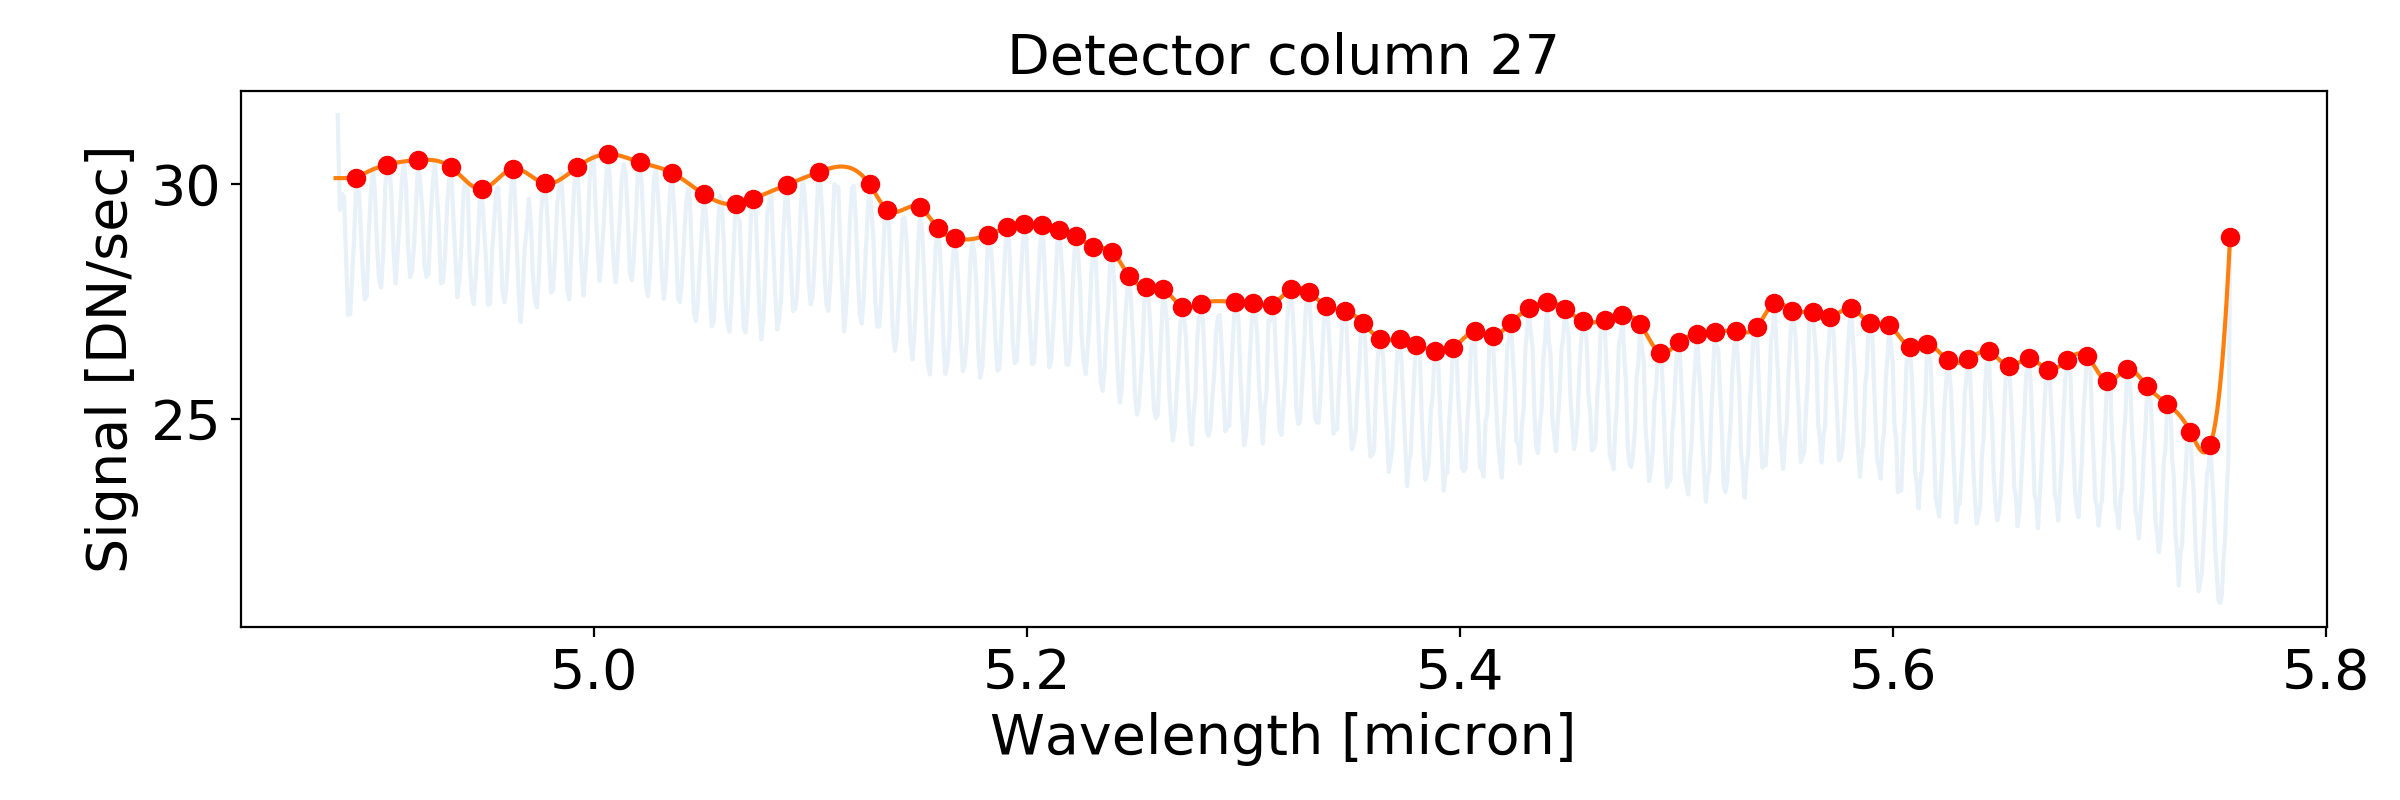

<IPython.core.display.Javascript object>


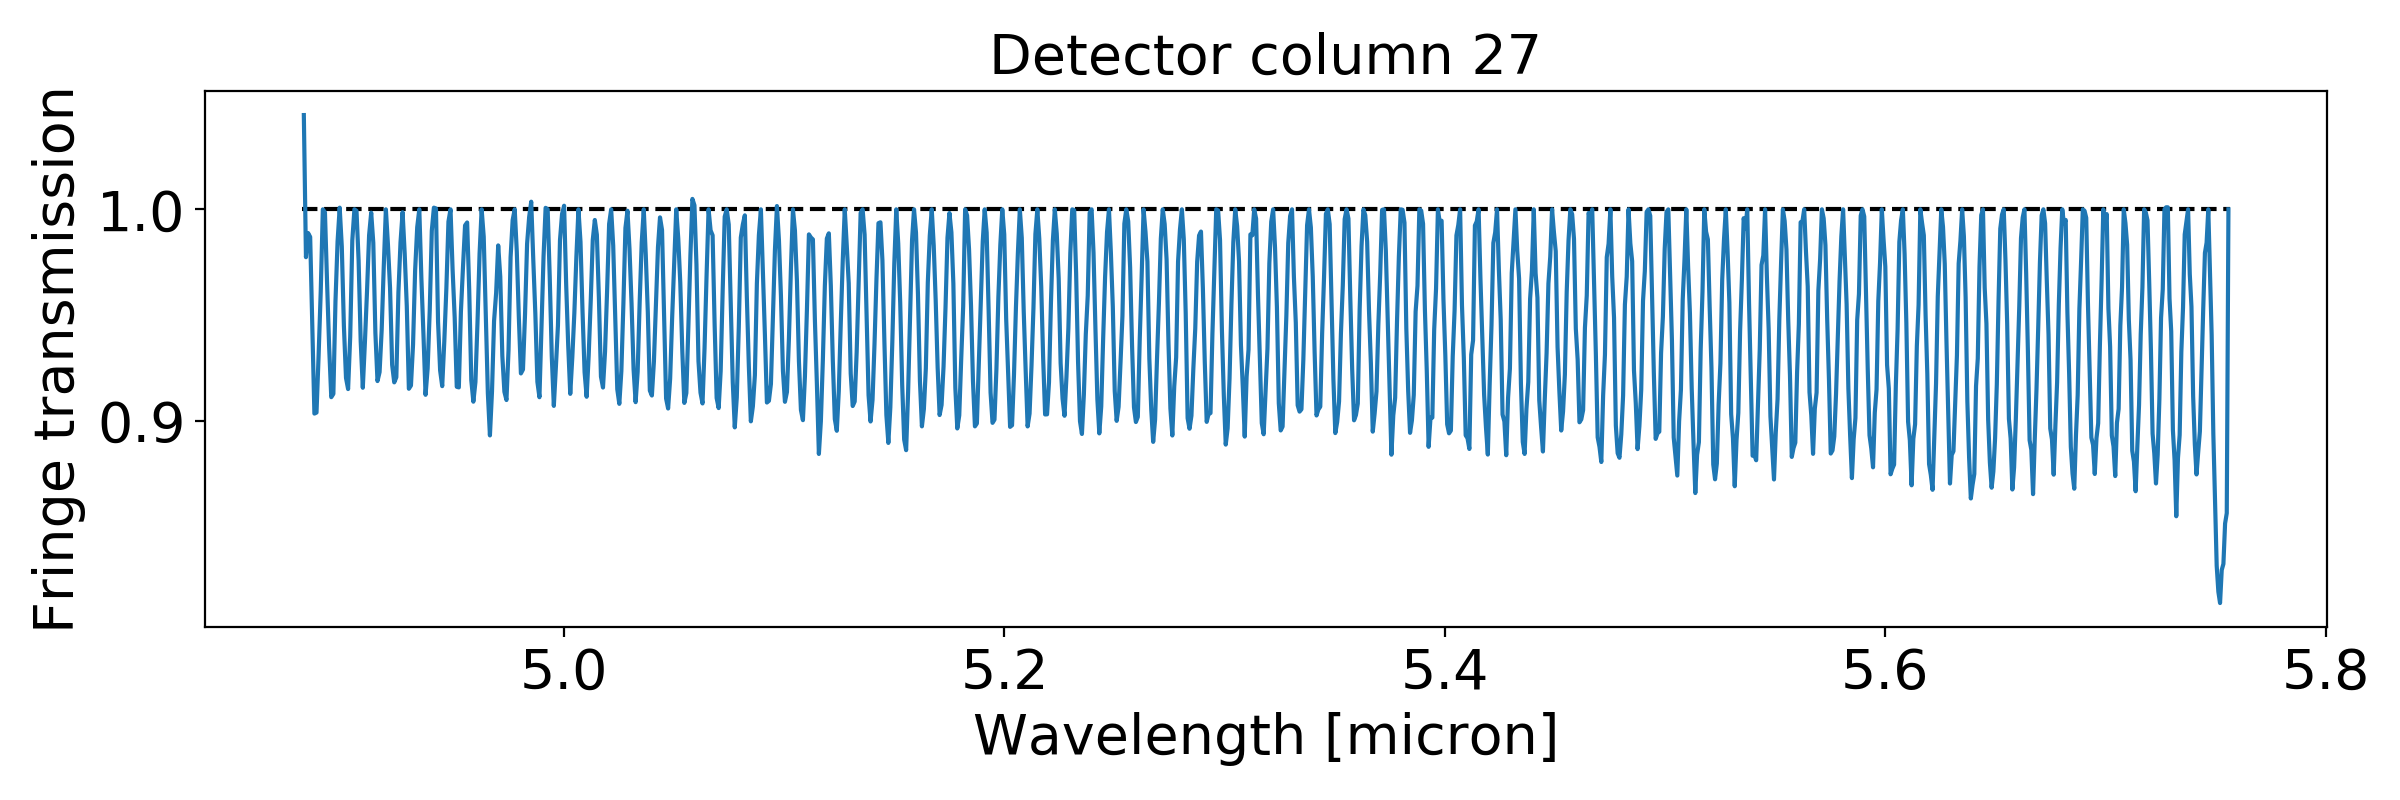

In [20]:
xcol = 27
example_spectrum = sci_exp_slope[:,xcol]
example_spectrum_norm = funcs.norm_fringe(example_spectrum,min_dist=8)

plt.figure(figsize=(12,4))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol][1:-1],example_spectrum_norm[0][1:-1],alpha=0.1)
plt.plot(lambdaMap[:,xcol],example_spectrum_norm[2])
plt.plot(lambdaMap[:,xcol][example_spectrum_norm[1]],example_spectrum_norm[0][example_spectrum_norm[1]],'ro')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol][1:-1],(example_spectrum_norm[0]/example_spectrum_norm[2])[1:-1])
plt.hlines(1,lambdaMap[:,xcol][0],lambdaMap[:,xcol][-1],'k',linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Fringe transmission')
plt.tight_layout()

**Apply spectrophotometric correction**

<IPython.core.display.Javascript object>


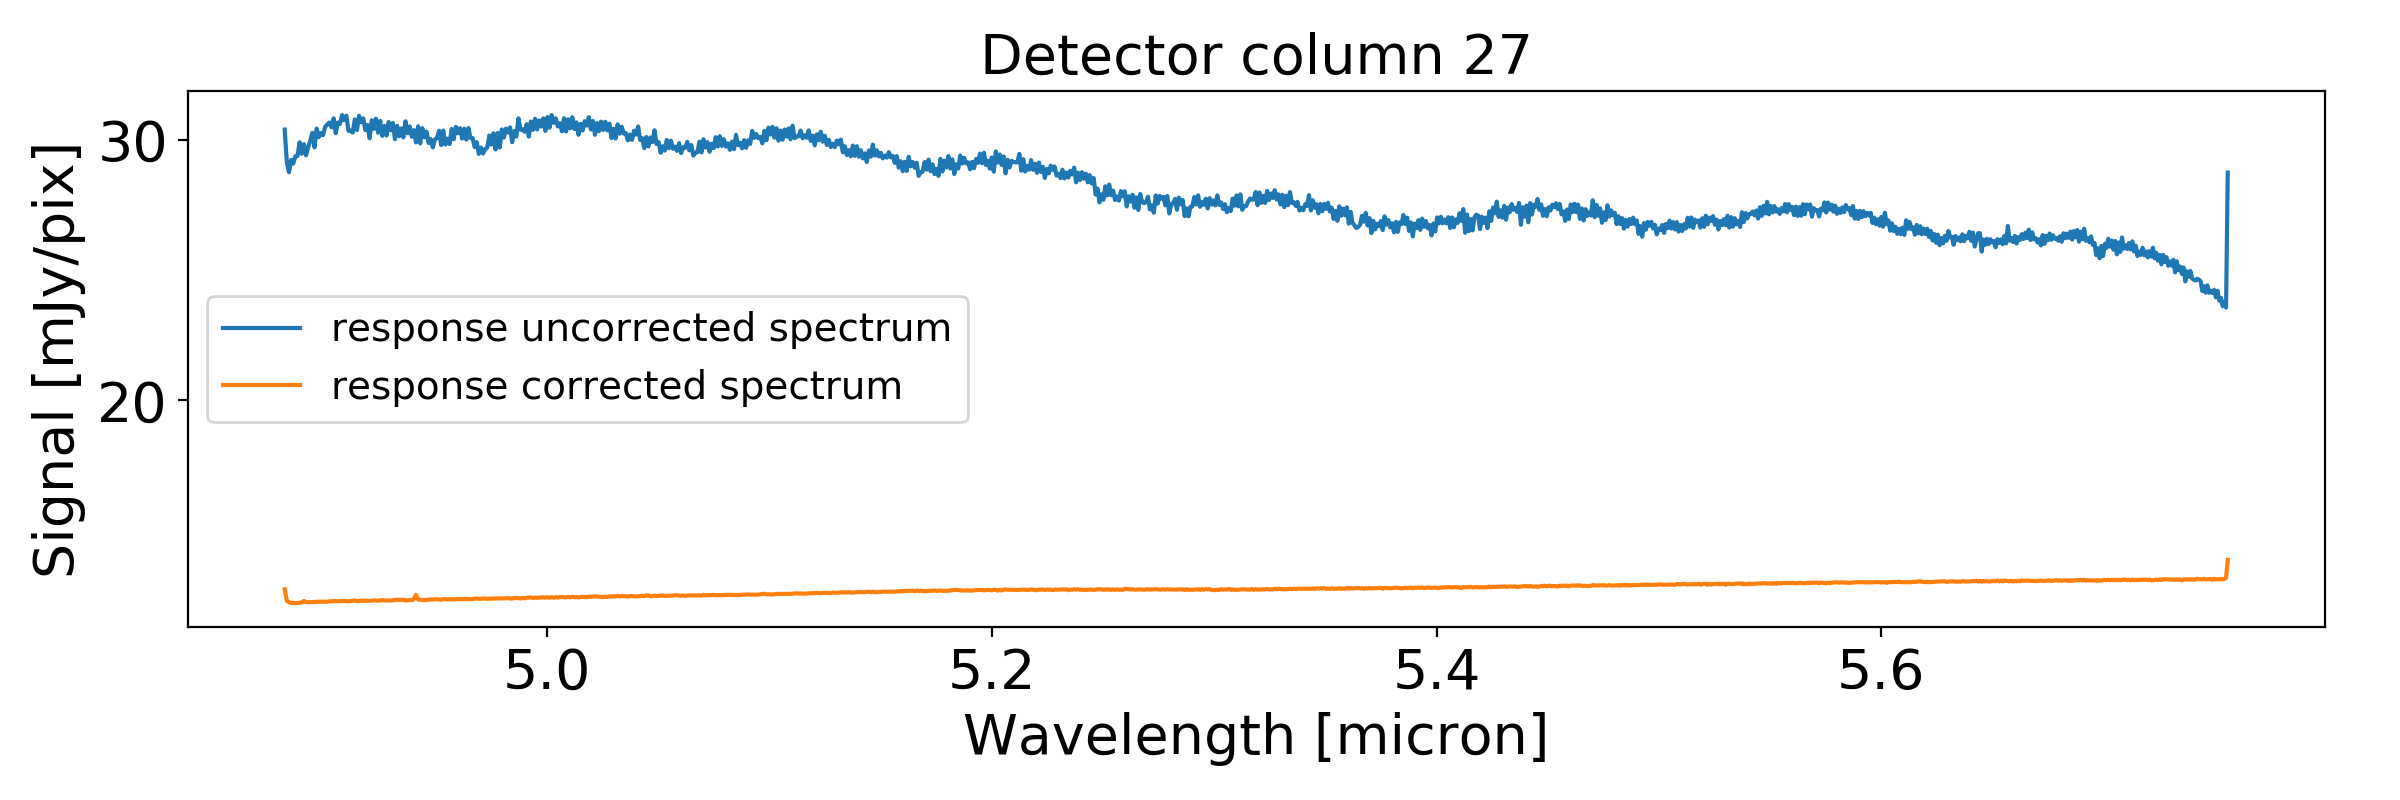

<IPython.core.display.Javascript object>


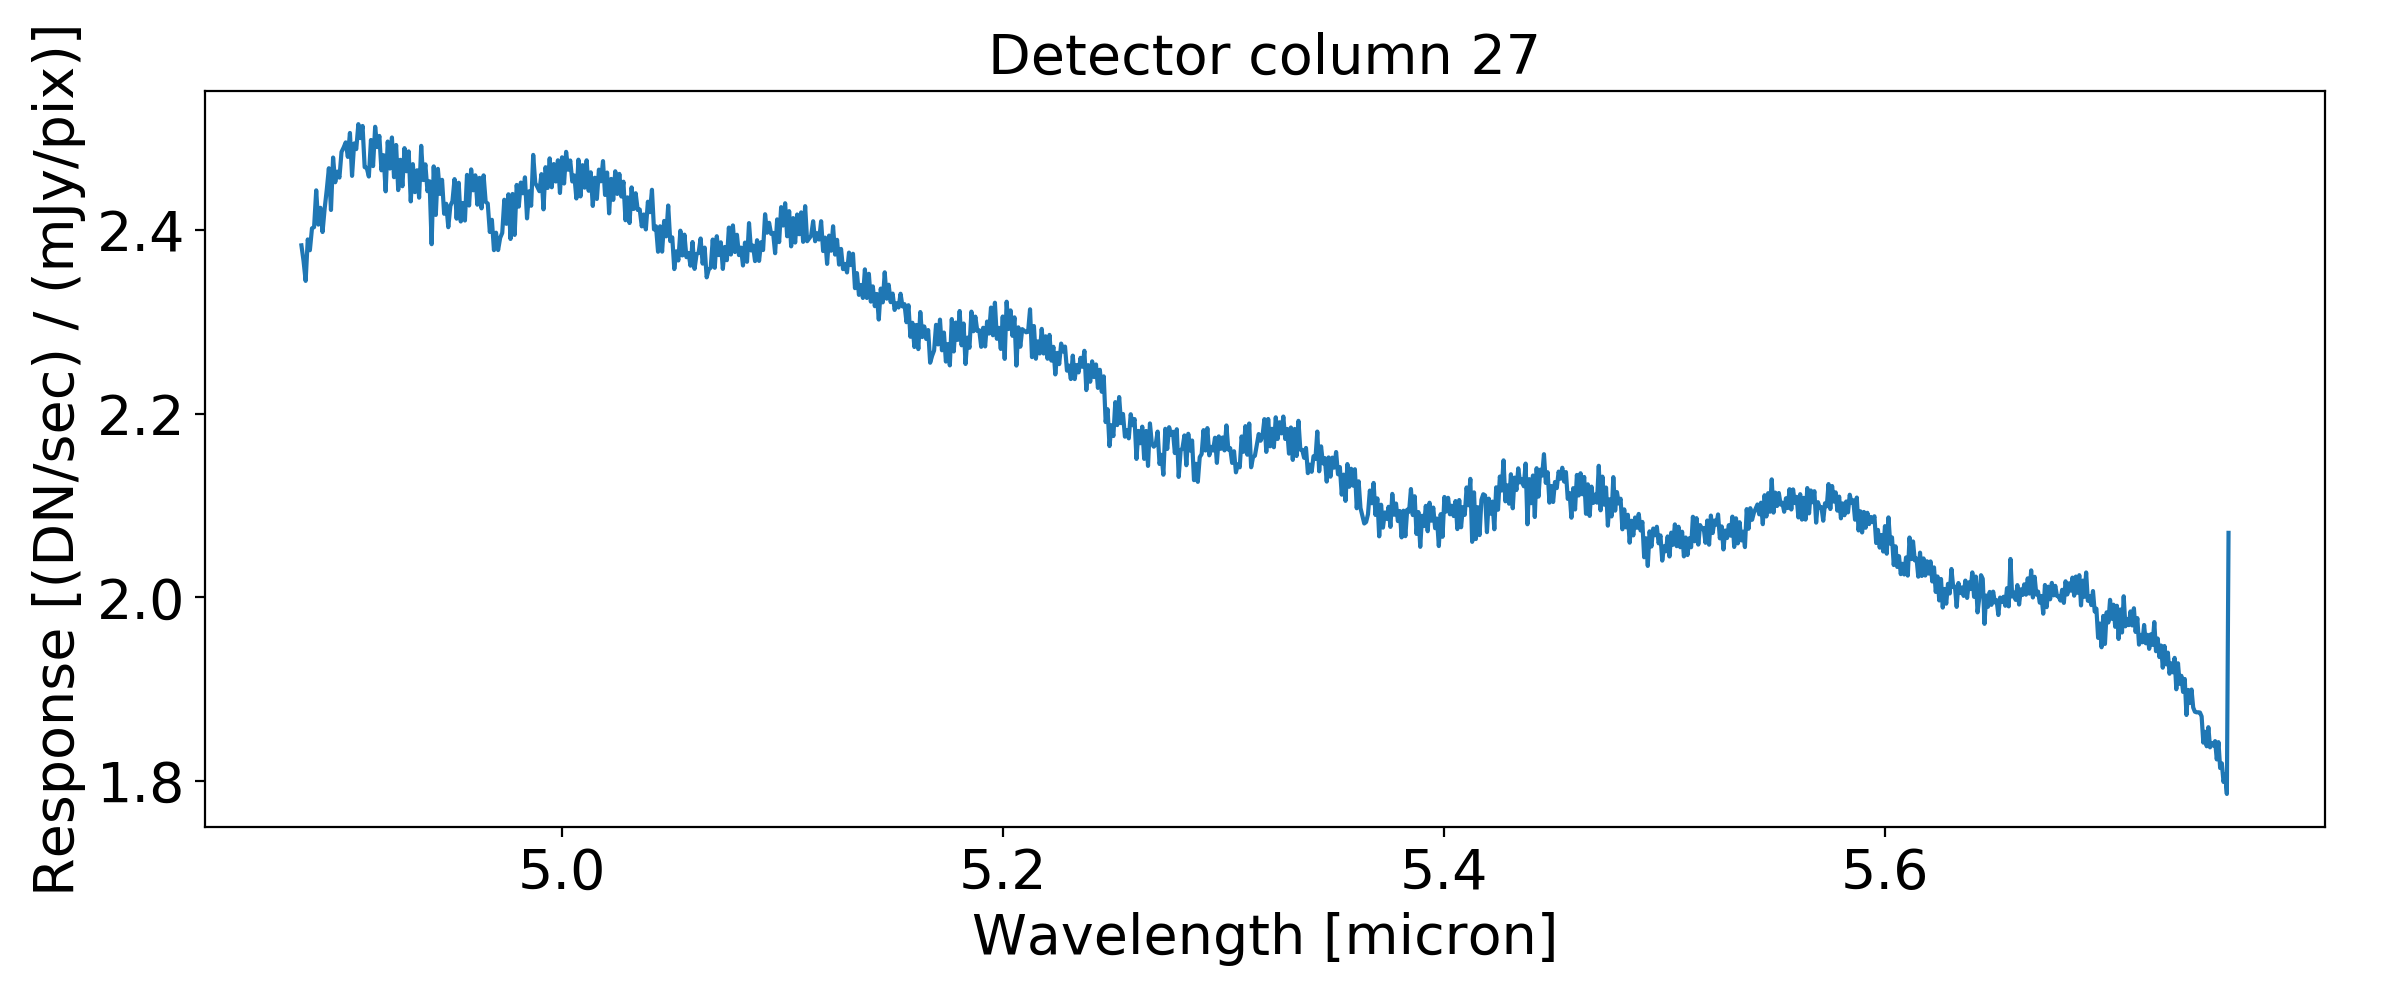

In [21]:
photom_img = funcs.get_cdps('1A',cdpDir)[1]
sci_exp_slope_photomCorr = sci_exp_slope_fringeCorr/photom_img

plt.figure(figsize=(12,4))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],sci_exp_slope_fringeCorr[:,xcol],label='response uncorrected spectrum')
plt.plot(lambdaMap[:,xcol],sci_exp_slope_photomCorr[:,xcol],label='response corrected spectrum')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [mJy/pix]')
plt.legend(loc='center left')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],photom_img[:,xcol])
plt.xlabel('Wavelength [micron]')
plt.ylabel('Response [(DN/sec) / (mJy/pix)]')
plt.tight_layout()

**Apply correction for detector pixel angular size (~plate scale)**

<IPython.core.display.Javascript object>


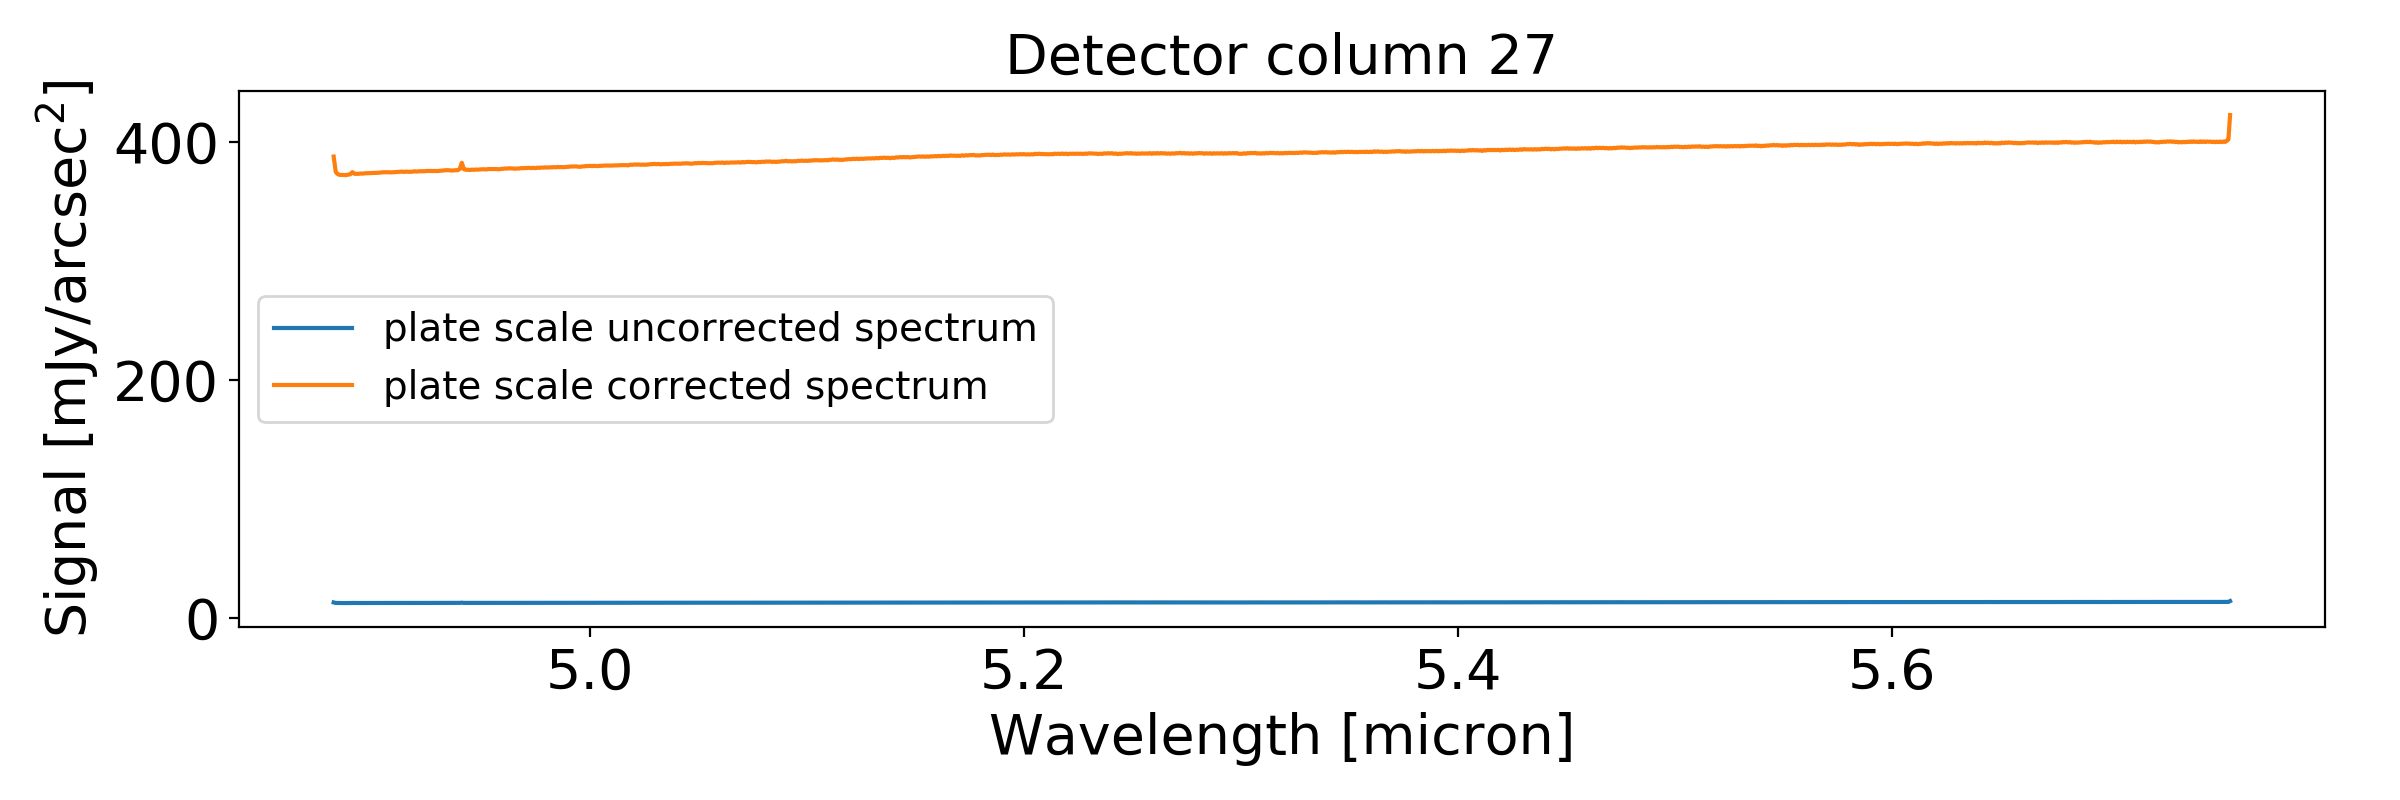

<IPython.core.display.Javascript object>


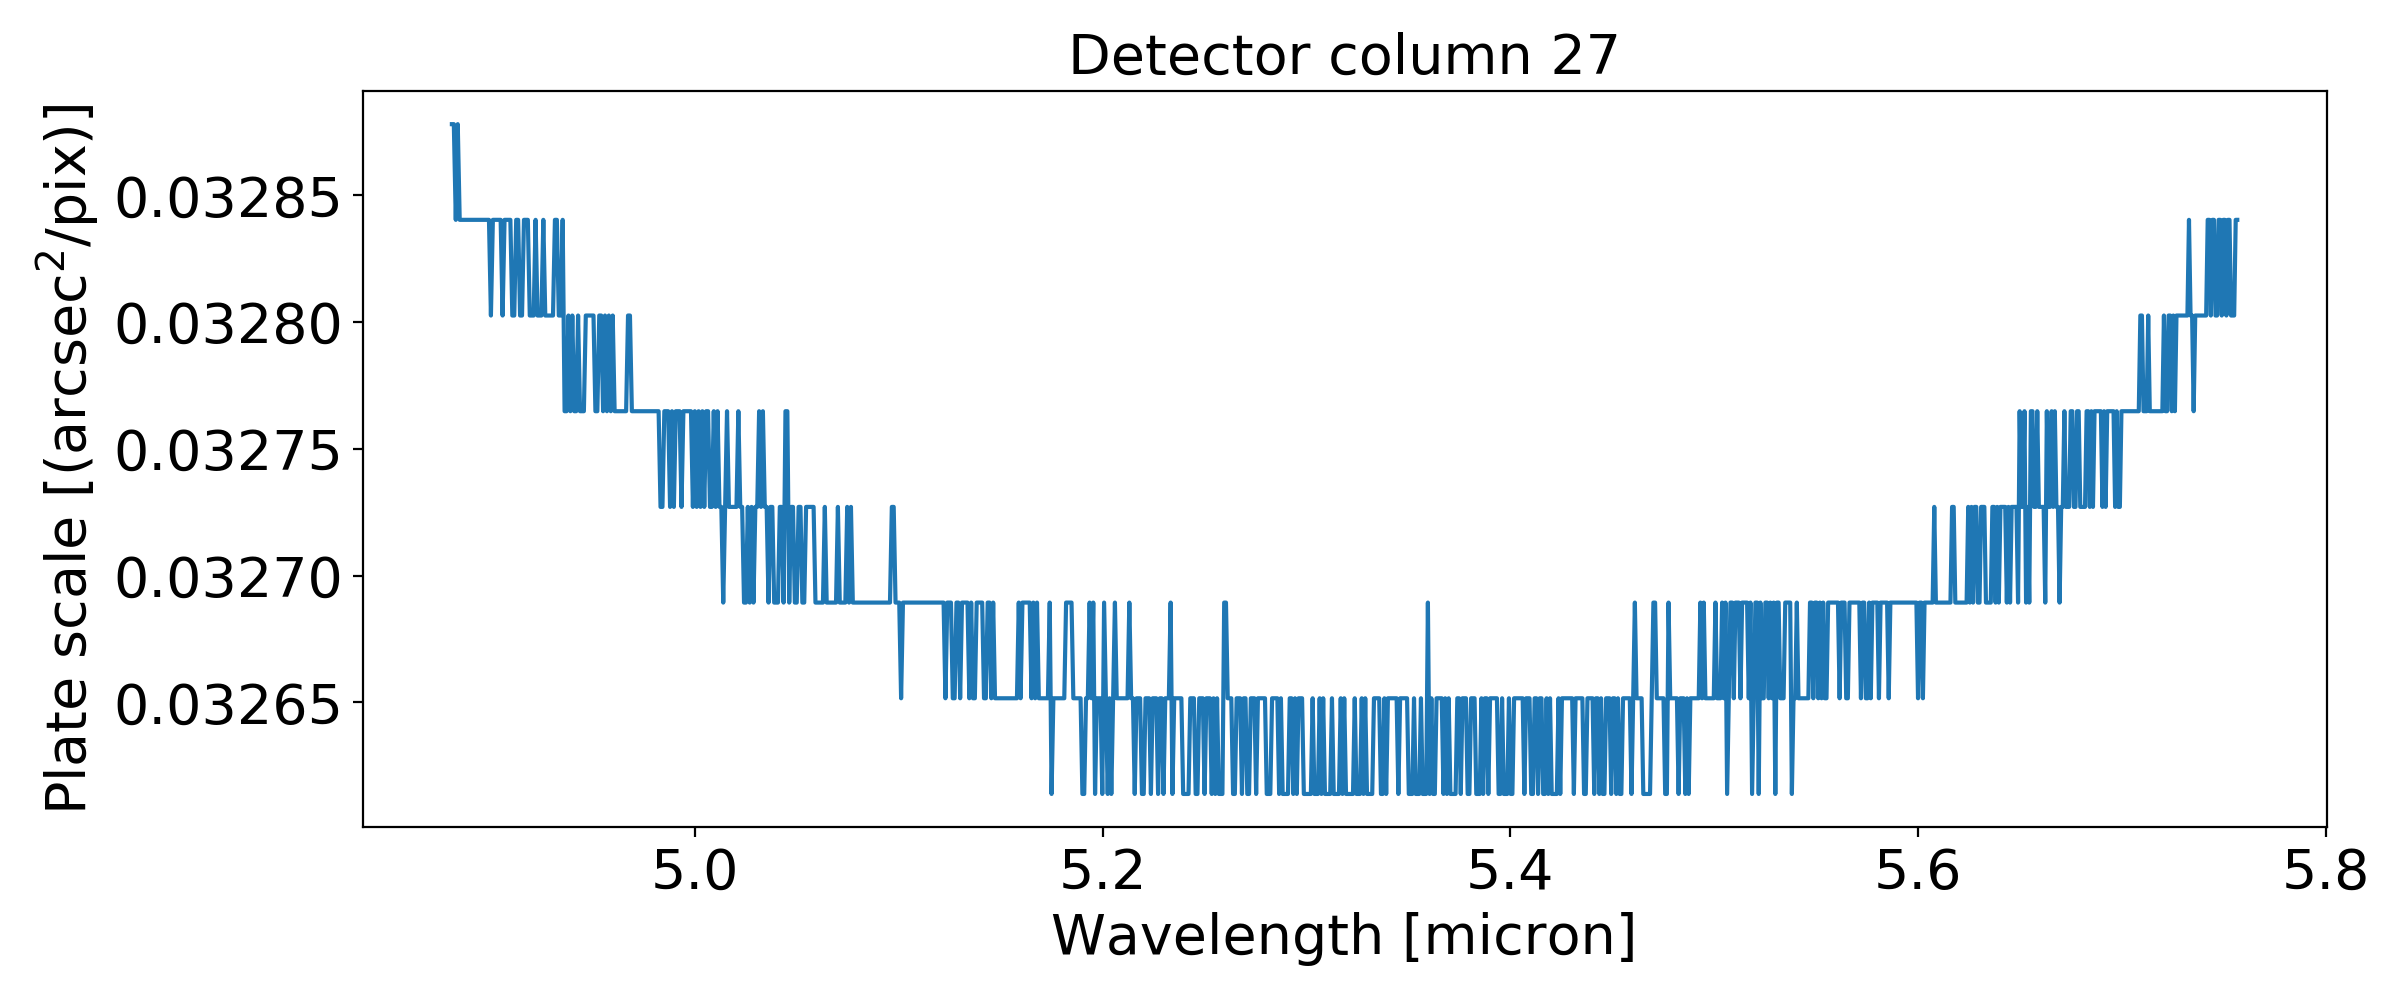

In [22]:
pixsiz_img = funcs.get_cdps('1A',cdpDir)[2]
sci_exp_slope_pixsizCorr = sci_exp_slope_photomCorr/pixsiz_img

plt.figure(figsize=(12,4))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],sci_exp_slope_photomCorr[:,xcol],label='plate scale uncorrected spectrum')
plt.plot(lambdaMap[:,xcol],sci_exp_slope_pixsizCorr[:,xcol],label='plate scale corrected spectrum')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [mJy/arcsec$^2$]')
plt.legend(loc='center left')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.title('Detector column {}'.format(xcol))
plt.plot(lambdaMap[:,xcol],pixsiz_img[:,xcol])
plt.xlabel('Wavelength [micron]')
plt.ylabel('Plate scale [(arcsec$^2$/pix)]')
plt.tight_layout()

**Detector spectral binning**

<IPython.core.display.Javascript object>


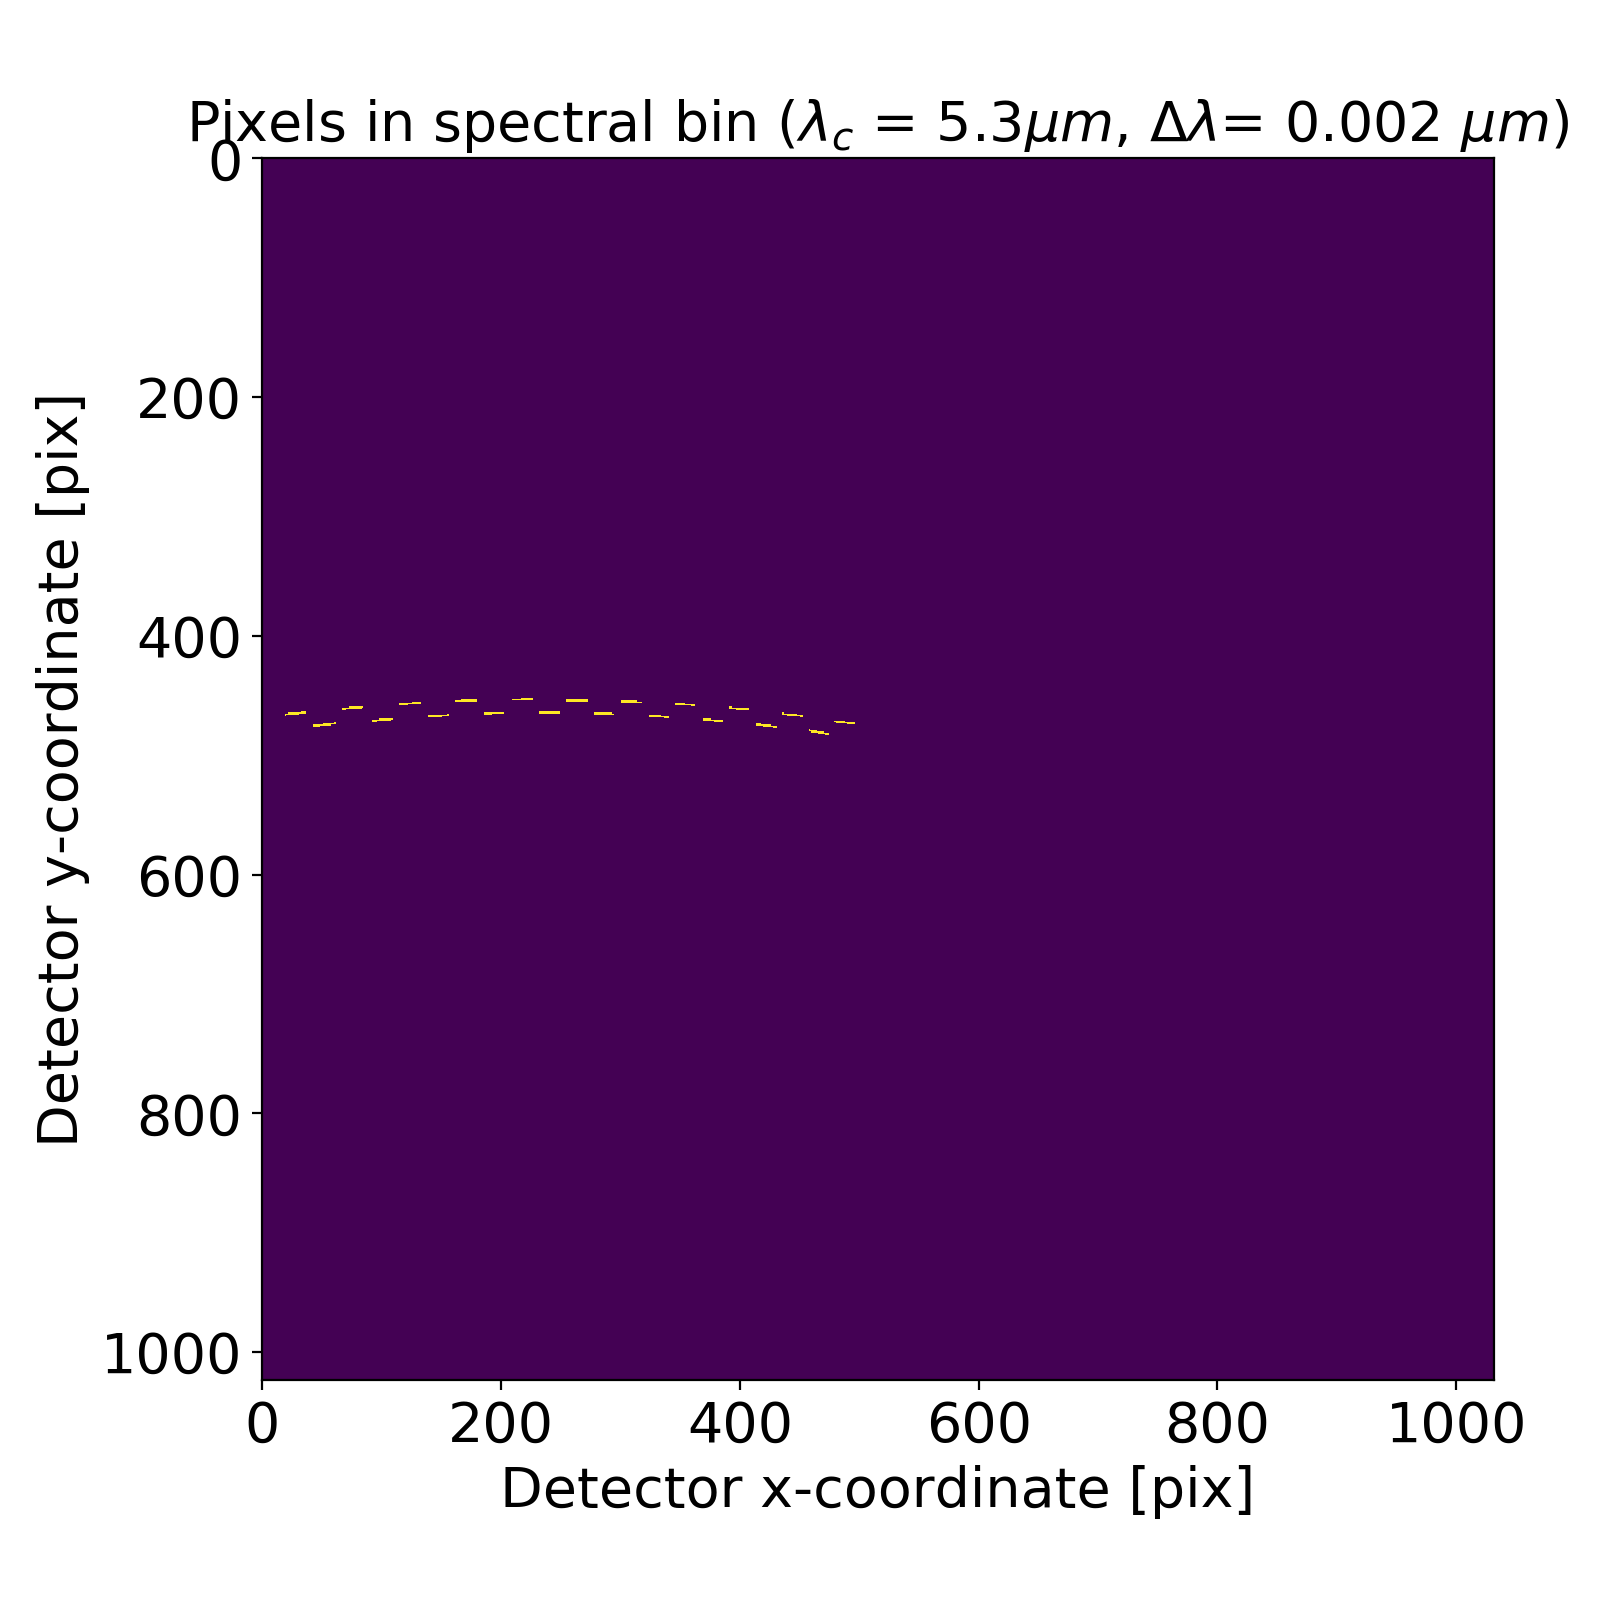

In [23]:
specres_table = funcs.get_cdps('1A',cdpDir)[4]
lambcens,lambfwhms = funcs.spectral_gridding('1A',d2cMaps,specres_table=specres_table)

ibin = int(len(lambcens)/2) +1
selectedpixelMap = np.zeros((1024,1032))
selectedpixelMap[(abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)] = 1.

plt.figure(figsize=(8,8))
plt.imshow(selectedpixelMap,interpolation='None',aspect='equal')
plt.title(r'Pixels in spectral bin ($\lambda_c$ = {}$\mu m$, $\Delta\lambda$= {} $\mu m$)'.format(round(lambcens[ibin],1),round(lambfwhms[ibin],3)))
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Detector y-coordinate [pix]')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

**Perform aperture photometry**

In [24]:
# define aperture shape
# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
ellipse = ((0, 0),(1, 1),0)

# Let create a circle of radius 1 around center point:
circ = shapely.geometry.Point(ellipse[0]).buffer(1)

# Let create the ellipse along x and y:
ell  = shapely.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

# Let rotate the ellipse (clockwise, x axis pointing right):
ellr = shapely.affinity.rotate(ell,ellipse[2])

# save final output as the aperture and calculate the aperture area
aperture = ellr
aperture_area = aperture.area

In [25]:
# create weight map with the pixel signal contributions (percentage area overlap with defined aperture)
weight_map = funcs.pixel_signal_contribution(d2cMaps,aperture,spec_grid=[lambcens,lambfwhms])

Pixel weight mapping
0/599 bins processed
100/599 bins processed
200/599 bins processed
300/599 bins processed
400/599 bins processed
500/599 bins processed
599/599 bins processed


In [26]:
# perform 1d aperture extraction
aperture_extracted_signal = funcs.aperture_weighted_photometry_extended_source(sci_exp_slope_pixsizCorr,weight_map,aperture_area,d2cMaps,spec_grid=[lambcens,lambfwhms])

<IPython.core.display.Javascript object>


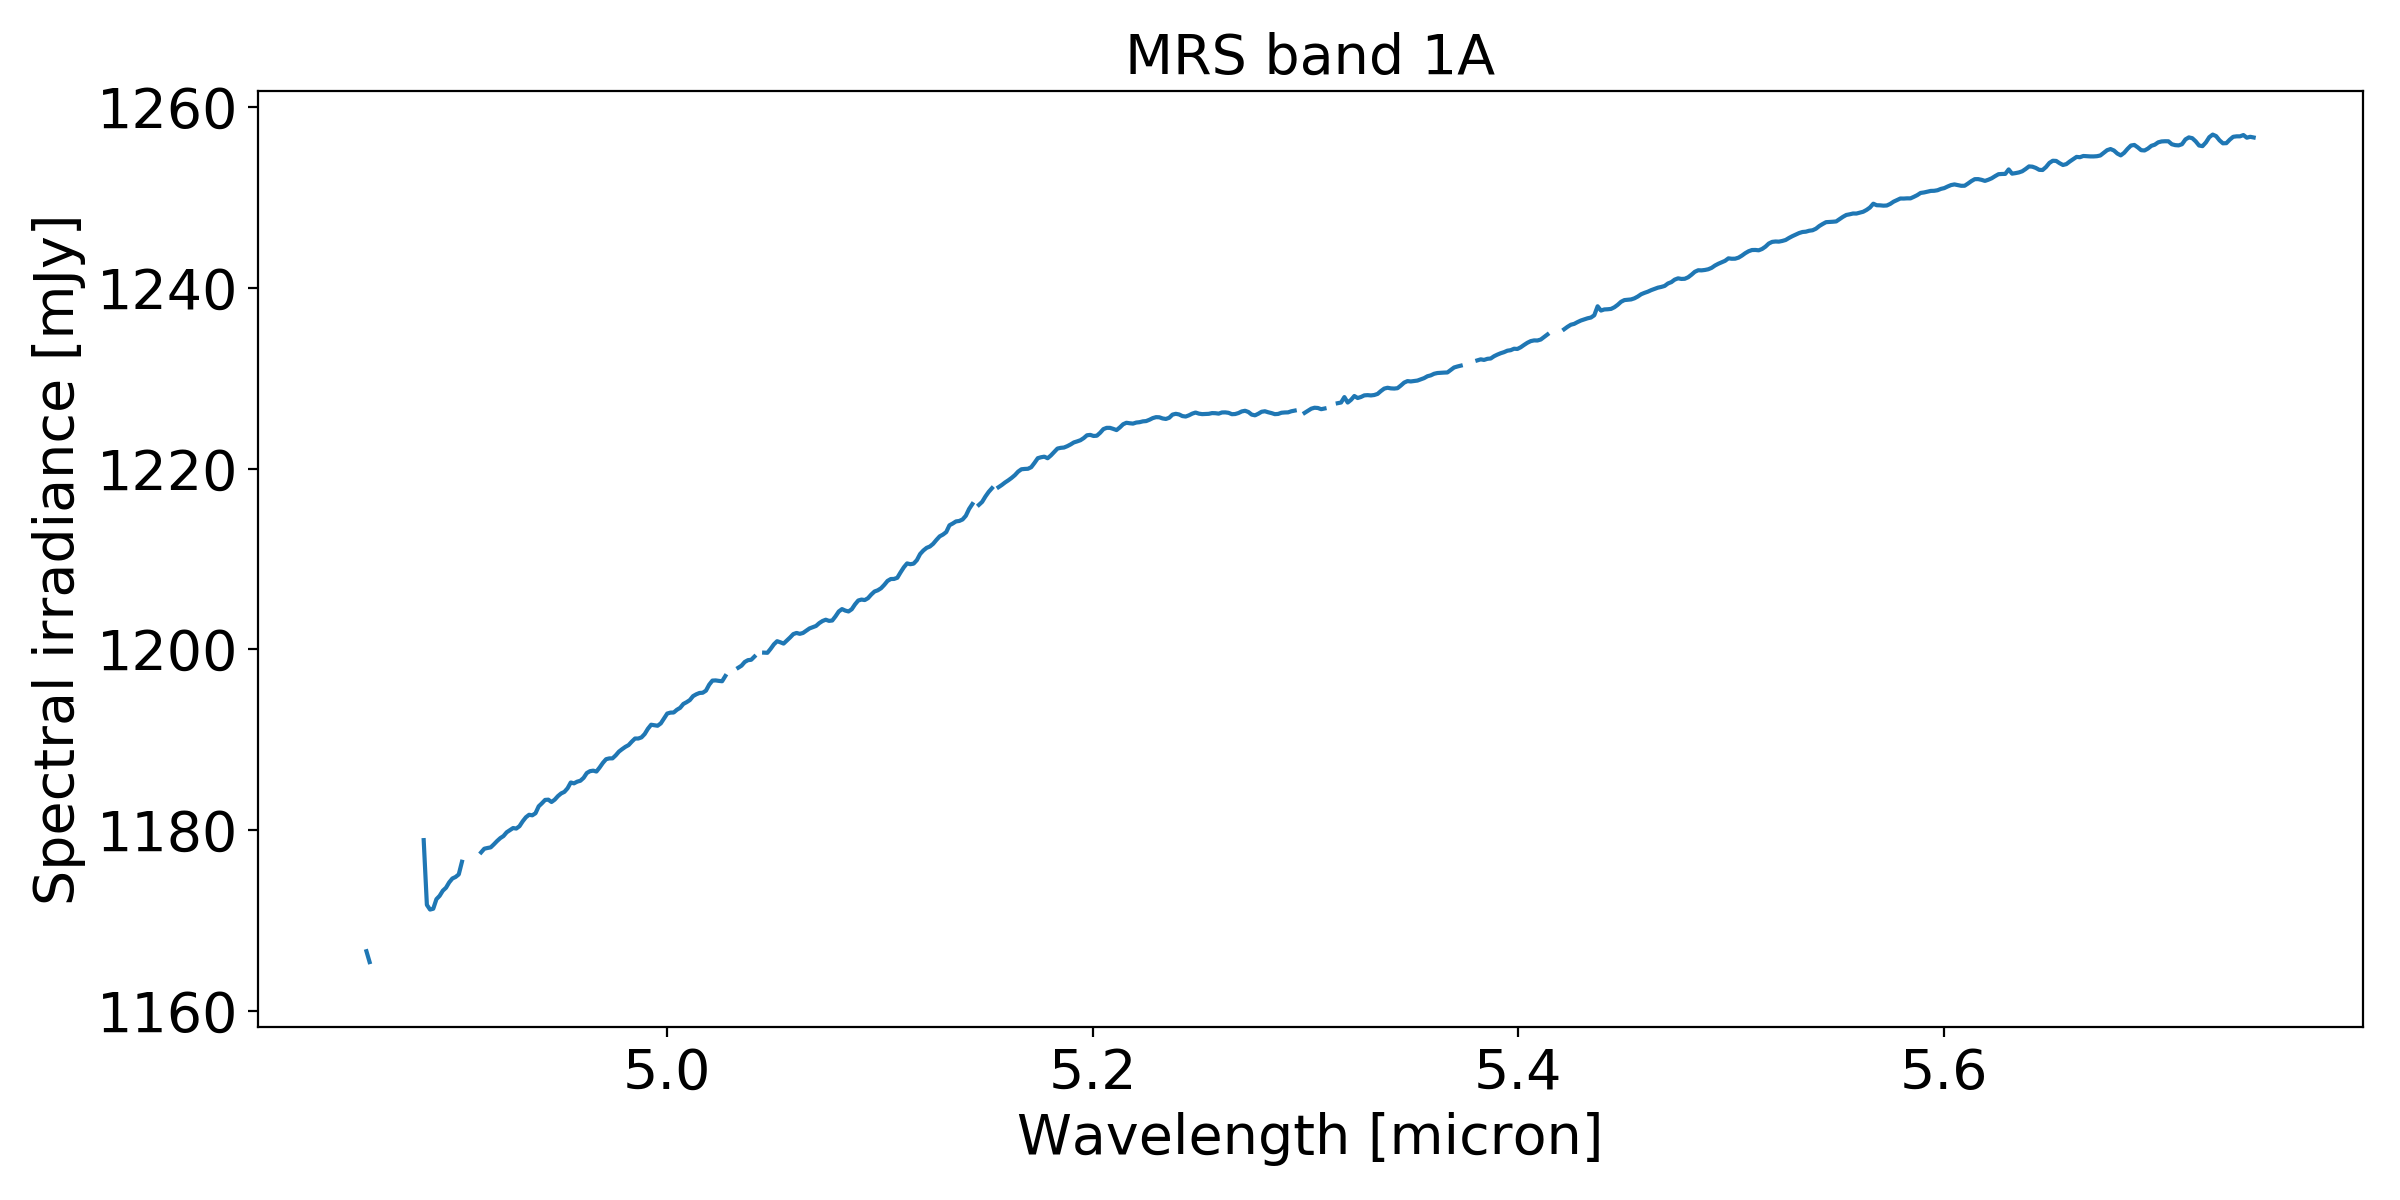

In [27]:
# plot extracted spectrum
plt.figure(figsize=(12,6))
plt.plot(lambcens,aperture_extracted_signal)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel(r'Spectral irradiance [mJy]',fontsize=20)
plt.title('MRS band {}'.format('1A'),fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()